<a href="https://colab.research.google.com/github/dethhe/nlpcc-ui-2025/blob/main/Class_2_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Eksplorasi Teks dengan Regex: Analisis Email Spam Indonesia

Ini adalah notebook untuk tugas Class 2: Regex Explorations in Text Data. Kita akan menggunakan dataset "Indonesian Email Spam" (`email_spam_indo.csv`) untuk mengeksplorasi berbagai pola teks menggunakan Regular Expressions (Regex) dengan library `re` di Python.

Untuk tugas eksplorasi Regular Expressions (Regex) ini, saya memilih dataset Indonesian Email Spam. Alasan utama pemilihan dataset ini adalah karena teks email seringkali mengandung berbagai pola yang dapat diekstraksi dan dianalisis secara efektif menggunakan Regex, seperti alamat email, nomor telepon, URL, dan frasa kunci tertentu yang dapat membantu membedakan antara email spam dan non-spam (ham).

## 1. Setup Awal

Pertama, kita akan mengimpor library yang diperlukan dan menghubungkan notebook ini ke Google Drive untuk mengakses dataset.

In [ ]:
# Sel 1: Impor Library
import pandas as pd
import re  # Library untuk regular expressions
from google.colab import drive
import csv # Untuk opsi quoting jika diperlukan

print("Libraries imported.")

Libraries imported.


### 1.1 Hubungkan ke Google Drive

Selanjutnya, kita akan me-mount Google Drive agar dapat mengakses file dataset.

In [ ]:
# Sel 2: Hubungkan ke Google Drive
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"Error saat mounting Google Drive: {e}")
    # Tidak perlu raise error jika sudah mounted, pandas akan gagal jika path salah
    if "already mounted" in str(e).lower():
        print("Drive already mounted.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.


## 2. Memuat dan Mempersiapkan Dataset

Kita akan memuat dataset `email_spam_indo.csv` dari Google Drive. Kode di bawah ini mencakup beberapa strategi untuk menangani potensi masalah saat parsing file CSV.

### 2.1 Definisi Path dan Pemuatan Dataset

In [ ]:
# Sel 3: Definisi Path dan Pemuatan Dataset
# --- SESUAIKAN PATH FILE ANDA DI GOOGLE DRIVE ---
path_to_email_csv = '/content/drive/MyDrive/Dataset NLP/email_spam_indo.csv'
# Pastikan path di atas sudah benar sesuai dengan lokasi file Anda di Google Drive.

df_email = None
print(f"Mencoba memuat dataset dari: {path_to_email_csv}")

try:
    print("Mencoba memuat dengan engine='python', on_bad_lines='skip'...")
    df_email = pd.read_csv(path_to_email_csv, engine='python', on_bad_lines='skip')
    print("Dataset berhasil dimuat dengan engine='python' dan on_bad_lines='skip'.")

    if df_email.empty:
        print("PERINGATAN: Dataframe kosong. Mencoba strategi lain.")
        df_email = None # Reset untuk percobaan berikutnya
    elif len(df_email.columns) < 2:
        print(f"PERINGATAN: Dataframe hanya memiliki {len(df_email.columns)} kolom. Ini mungkin tidak benar. Kolom: {df_email.columns.tolist()}")
        df_email = None # Anggap gagal jika kolom terlalu sedikit

except Exception as e_initial:
    print(f"Error pada percobaan awal dengan on_bad_lines='skip': {e_initial}")
    df_email = None

if df_email is None: # Jika percobaan pertama gagal
    print("\nMencoba memuat dengan engine='python', quoting=csv.QUOTE_ALL, on_bad_lines='skip'...")
    try:
        # Menggunakan quoting=csv.QUOTE_ALL bisa membantu jika ada masalah dengan quote dalam data
        # on_bad_lines='skip' tetap digunakan untuk melewati baris yang benar-benar bermasalah
        df_email = pd.read_csv(path_to_email_csv, engine='python', quoting=csv.QUOTE_ALL, on_bad_lines='skip')
        print("Dataset berhasil dimuat dengan engine='python', quoting=csv.QUOTE_ALL, dan on_bad_lines='skip'.")
        if df_email.empty:
            print("PERINGATAN: Dataframe kosong setelah percobaan dengan QUOTE_ALL.")
        elif len(df_email.columns) < 2:
             print(f"PERINGATAN: Dataframe dengan QUOTE_ALL hanya memiliki {len(df_email.columns)} kolom. Kolom: {df_email.columns.tolist()}")
             # Jika kolom masih sedikit, mungkin ada masalah fundamental dengan CSV atau path
    except Exception as e_quote_all:
        print(f"Error saat memuat dengan QUOTE_ALL: {e_quote_all}")
        df_email = None # Gagal total

# Cek final setelah semua percobaan
if df_email is None:
    print("\nGAGAL MEMUAT DATASET setelah semua percobaan. Periksa path file dan integritas file CSV.")
elif df_email.empty:
    print("\nDataset berhasil dimuat tetapi KOSONG. Periksa isi file CSV Anda.")
else:
    print("\nDataset berhasil dimuat.")

Mencoba memuat dataset dari: /content/drive/MyDrive/Dataset NLP/email_spam_indo.csv
Mencoba memuat dengan engine='python', on_bad_lines='skip'...
Dataset berhasil dimuat dengan engine='python' dan on_bad_lines='skip'.

Dataset berhasil dimuat.


### 2.2 Inspeksi, Pembersihan, dan Penyesuaian Kolom

Setelah dataset dimuat, kita akan melakukan inspeksi awal, mengganti nama kolom agar lebih standar, dan menangani nilai yang hilang.

In [ ]:
# Sel 4: Inspeksi, Pembersihan, dan Penyesuaian Kolom
if 'df_email' in globals() and df_email is not None and not df_email.empty:
    print("\n--- Informasi Awal Dataset ---")
    print("Nama kolom aktual:", df_email.columns.tolist())
    print("Beberapa baris pertama (head):")
    print(df_email.head())

    # --- PENYESUAIAN NAMA KOLOM ---
    if len(df_email.columns) >= 2:
        kolom_label_aktual = df_email.columns[0]
        kolom_teks_aktual = df_email.columns[1]

        nama_kolom_label_baru = 'label'
        nama_kolom_teks_baru = 'teks'

        df_email.rename(columns={
            kolom_label_aktual: nama_kolom_label_baru,
            kolom_teks_aktual: nama_kolom_teks_baru
        }, inplace=True)

        print("\n--- Setelah Rename Kolom ---")
        print("Nama kolom baru:", df_email.columns.tolist())
        print("Beberapa baris pertama (head) setelah rename:")
        print(df_email.head())

        kolom_label = nama_kolom_label_baru
        kolom_teks = nama_kolom_teks_baru

        print("\nInfo DataFrame setelah rename:")
        df_email.info()

        print(f"\nJumlah nilai unik di kolom '{kolom_label}':")
        print(df_email[kolom_label].value_counts())

        if df_email[kolom_label].dtype == 'object':
            unique_labels = df_email[kolom_label].unique()
            print(f"Label unik sebelum mapping: {unique_labels}")

            label_map = {}
            for ul in unique_labels:
                if isinstance(ul, str):
                    ul_lower = ul.lower() # Konversi ke lowercase untuk matching
                    if 'spam' in ul_lower:
                        label_map[ul] = 1
                    elif 'ham' in ul_lower or 'non-spam' in ul_lower or 'bukan spam' in ul_lower:
                        label_map[ul] = 0

            if label_map:
                print(f"Mapping yang akan diterapkan: {label_map}")
                df_email[kolom_label] = df_email[kolom_label].map(label_map)
                print(f"\nJumlah nilai unik di kolom '{kolom_label}' setelah mapping:")
                print(df_email[kolom_label].value_counts(dropna=False))
            else:
                print("Tidak dapat membuat mapping otomatis untuk label. Periksa nilai unik.")

        print(f"\nJumlah nilai kosong di kolom '{kolom_teks}' sebelum penanganan: {df_email[kolom_teks].isnull().sum()}")
        df_email.dropna(subset=[kolom_teks, kolom_label], inplace=True)
        df_email[kolom_teks] = df_email[kolom_teks].astype(str)

        # --- TAMBAHAN: Membersihkan trailing semicolons dari kolom 'teks' ---
        print(f"\nMembersihkan trailing semicolons dari kolom '{kolom_teks}'...")
        df_email[kolom_teks] = df_email[kolom_teks].str.rstrip(';')
        print("Pembersihan trailing semicolons selesai.")
        # --- AKHIR TAMBAHAN ---

        print(f"\nJumlah nilai kosong di kolom '{kolom_teks}' setelah penanganan dan pembersihan: {df_email[kolom_teks].isnull().sum()}")
        print(f"Jumlah nilai kosong di kolom '{kolom_label}' setelah penanganan: {df_email[kolom_label].isnull().sum()}")

        # Hapus baris di mana label mungkin menjadi NaN setelah mapping (jika ada label yang tidak dikenal)
        df_email.dropna(subset=[kolom_label], inplace=True)
        # Konversi kolom label ke integer jika berhasil dimapping
        if pd.api.types.is_numeric_dtype(df_email[kolom_label]):
             df_email[kolom_label] = df_email[kolom_label].astype(int)


        print(f"\nTotal jumlah email yang akan dianalisis: {len(df_email)}")

        if not df_email.empty:
            sample_email_text_from_df = df_email[kolom_teks].sample(1, random_state=42).iloc[0]
            print("\n--- Contoh Teks Email dari DataFrame (Setelah Pembersihan) ---")
            print(sample_email_text_from_df[:500] + "..." if len(sample_email_text_from_df) > 500 else sample_email_text_from_df)
        else:
            print("Dataframe kosong setelah membersihkan nilai NaN, tidak bisa mengambil contoh email.")
    else:
        print("Dataset tidak memiliki cukup kolom untuk diproses (minimal 2 kolom diperlukan).")

elif df_email is not None and df_email.empty:
    print("\nDataset email berhasil dimuat tetapi KOSONG. Periksa file CSV Anda.")
else:
    print("\nDataset email GAGAL dimuat atau tidak terdefinisi. Tidak dapat melanjutkan.")


--- Informasi Awal Dataset ---
Nama kolom aktual: ['label', 'teks']
Beberapa baris pertama (head):
   label                                               teks
0      1  Simpan uang Anda beli untuk mendapatkan barang...
1      1  Simpan uang Anda beli untuk mendapatkan barang...
2      1  Simpan uang Anda beli untuk mendapatkan barang...
3      1  Peringatan Keamanan - Konfirmasikan Informasi ...
4      1  mengandalkan kami untuk pemesanan resep online...

--- Setelah Rename Kolom ---
Nama kolom baru: ['label', 'teks']
Beberapa baris pertama (head) setelah rename:
   label                                               teks
0      1  Simpan uang Anda beli untuk mendapatkan barang...
1      1  Simpan uang Anda beli untuk mendapatkan barang...
2      1  Simpan uang Anda beli untuk mendapatkan barang...
3      1  Peringatan Keamanan - Konfirmasikan Informasi ...
4      1  mengandalkan kami untuk pemesanan resep online...

Info DataFrame setelah rename:
<class 'pandas.core.frame.DataFrame'>

## 3. Goal 1: Menemukan Alamat Email

**Tujuan:** Mengidentifikasi semua alamat email yang valid dalam teks. Alamat email umumnya memiliki format `username@domain.ekstensi`. Kita akan mencoba beberapa variasi regex untuk menangkap format ini dengan lebih baik, termasuk menangani spasi yang mungkin muncul karena kesalahan OCR atau format yang tidak standar.

### 3.1 Persiapan Contoh Teks Statis

Untuk mengembangkan dan menguji variasi regex secara terkontrol, kita akan menggunakan beberapa contoh teks statis.

In [ ]:
# Sel 5: Persiapan Contoh Teks Statis untuk Pengujian Regex Awal
static_test_text_spam = "Contoh email spam: Menangkan hadiah! Kontak support@my-promo.info sekarang. Atau coba cs.promo@another.co.id. Jangan lewatkan! Info lebih lanjut di admin@website.com."
static_test_text_ham = "Permintaan Dikirim: Untuk Mark. Breese @ Enron. com. Pemberitahuan ke STINSON. Gibner @ Enron. com. Email resmi: official.contact@my-company.org. Ini bukan email: user@domain (tanpa tld) atau user@.com (tanpa domain)."

print("--- Contoh Teks SPAM (Statis) ---")
print(f"{static_test_text_spam}\n")
print("--- Contoh Teks HAM (Statis) ---")
print(f"{static_test_text_ham}\n")

# Kita akan menggunakan static_test_text_spam dan static_test_text_ham untuk demonstrasi variasi regex.
test_text_spam = static_test_text_spam
test_text_ham = static_test_text_ham

print("Contoh teks statis siap digunakan.")

--- Contoh Teks SPAM (Statis) ---
Contoh email spam: Menangkan hadiah! Kontak support@my-promo.info sekarang. Atau coba cs.promo@another.co.id. Jangan lewatkan! Info lebih lanjut di admin@website.com.

--- Contoh Teks HAM (Statis) ---
Permintaan Dikirim: Untuk Mark. Breese @ Enron. com. Pemberitahuan ke STINSON. Gibner @ Enron. com. Email resmi: official.contact@my-company.org. Ini bukan email: user@domain (tanpa tld) atau user@.com (tanpa domain).

Contoh teks statis siap digunakan.


In [ ]:
# Sel 6: Implementasi Variasi Regex untuk Goal 1

print("--- Menguji pada Contoh Email SPAM (Statis) ---")
print(f"Teks Asli (SPAM):\n{test_text_spam}\n")

print("--- Menguji pada Contoh Email HAM (Statis) ---")
print(f"Teks Asli (HAM):\n{test_text_ham}\n")

# Variasi 1: Pola Regex Sangat Dasar
print("\n--- Variasi 1: Pola Dasar (\\S+@\\S+\\.\\S+) ---")
regex_email_v1 = r"\S+@\S+\.\S+"
# Penjelasan:
# \S+ : Satu atau lebih karakter non-whitespace.
# @   : Karakter '@' literal.
# \.  : Karakter '.' literal (di-escape).
# Sangat longgar, bisa menangkap string yang bukan email valid (misalnya, jika ada titik di akhir).
matches_v1_spam = re.findall(regex_email_v1, test_text_spam)
print(f"Email ditemukan di teks SPAM (v1): {matches_v1_spam}")
matches_v1_ham = re.findall(regex_email_v1, test_text_ham)
print(f"Email ditemukan di teks HAM (v1): {matches_v1_ham}") # Akan menangkap 'Breese@Enron.com.' dan 'Gibner@Enron.com.'

# Variasi 2: Pola Lebih Spesifik untuk Karakter Username, Domain, dan TLD
print("\n--- Variasi 2: Pola Lebih Spesifik ([a-zA-Z0-9._-]+@[a-zA-Z0-9-]+\\.[a-zA-Z]{2,}) ---")
regex_email_v2 = r"[a-zA-Z0-9._-]+@[a-zA-Z0-9-]+\.[a-zA-Z]{2,}"
# Penjelasan:
# [a-zA-Z0-9._-]+ : Username (huruf, angka, ., _, -).
# @                 : Karakter '@' literal.
# [a-zA-Z0-9-]+    : Domain name (tanpa TLD). Terdiri dari huruf, angka, atau tanda hubung.
# \.                : Karakter '.' literal.
# [a-zA-Z]{2,}      : Top-Level Domain (TLD). Terdiri dari minimal 2 huruf.
# Lebih ketat, mengurangi false positives seperti titik di akhir, tapi belum menangani spasi.
matches_v2_spam = re.findall(regex_email_v2, test_text_spam)
print(f"Email ditemukan di teks SPAM (v2): {matches_v2_spam}")
matches_v2_ham = re.findall(regex_email_v2, test_text_ham)
print(f"Email ditemukan di teks HAM (v2): {matches_v2_ham}") # Tidak akan menemukan email dengan spasi

# Variasi 3: Menangani Subdomain dan Karakter Tambahan di Username
print("\n--- Variasi 3: Menangani Subdomain & Karakter Tambahan ([a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\\.[a-zA-Z]{2,}) ---")
regex_email_v3 = r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}"
# Penjelasan:
# [a-zA-Z0-9._%+-]+ : Username diperluas untuk mencakup '%' dan '+'.
# @                  : Karakter '@' literal.
# [a-zA-Z0-9.-]+     : Domain name. Sekarang memperbolehkan titik (untuk subdomain, misal mail.google.com) dan tanda hubung.
# \.                 : Karakter '.' literal.
# [a-zA-Z]{2,}       : TLD, minimal 2 huruf.
# Lebih fleksibel untuk format email yang lebih kompleks, tapi masih belum menangani spasi.
matches_v3_spam = re.findall(regex_email_v3, test_text_spam)
print(f"Email ditemukan di teks SPAM (v3): {matches_v3_spam}")
matches_v3_ham = re.findall(regex_email_v3, test_text_ham)
print(f"Email ditemukan di teks HAM (v3): {matches_v3_ham}") # Tidak akan menemukan email dengan spasi

# Variasi 4: Menangani Spasi Opsional di Sekitar '@' dan '.' (sering terjadi pada teks yang diekstrak)
print("\n--- Variasi 4: Menangani Spasi Opsional ([a-zA-Z0-9._%+-]+\\s*@\\s*[a-zA-Z0-9.-]+\\s*\\.\\s*[a-zA-Z]{2,}) ---")
regex_email_v4_match_full = r"[a-zA-Z0-9._%+-]+\s*@\s*[a-zA-Z0-9.-]+\s*\.\s*[a-zA-Z]{2,}"
# Penjelasan:
# \s* : Nol atau lebih karakter whitespace (spasi, tab, newline).
# Ditambahkan di sekitar '@' dan sebelum TLD.
# Hasilnya akan mengandung spasi, jadi perlu dibersihkan setelahnya.
matches_v4_spam_raw = re.findall(regex_email_v4_match_full, test_text_spam)
cleaned_matches_v4_spam = [re.sub(r'\s+', '', email).lower() for email in matches_v4_spam_raw]
print(f"Email ditemukan di teks SPAM (v4, raw): {matches_v4_spam_raw}")
print(f"Email ditemukan di teks SPAM (v4, dibersihkan, lowercase): {cleaned_matches_v4_spam}")

matches_v4_ham_raw = re.findall(regex_email_v4_match_full, test_text_ham)
cleaned_matches_v4_ham = [re.sub(r'\s+', '', email).lower() for email in matches_v4_ham_raw]
print(f"Email ditemukan di teks HAM (v4, raw): {matches_v4_ham_raw}")
print(f"Email ditemukan di teks HAM (v4, dibersihkan, lowercase): {cleaned_matches_v4_ham}")

# Variasi 5: TLD lebih ketat, case-insensitive flag, dan negative lookahead
print("\n--- Variasi 5: TLD lebih ketat (2-6 char), case-insensitive, spasi, negative lookahead ---")
regex_email_v5 = r"[a-z0-9._%+-]+\s*@\s*[a-z0-9.-]+\s*\.\s*[a-z]{2,6}(?![a-z0-9@])"
# Penjelasan:
# [a-z0-9._%+-]+ : Username (huruf kecil karena re.IGNORECASE akan menangani huruf besar).
# \s*@\s*          : '@' dengan spasi opsional.
# [a-z0-9.-]+     : Domain (huruf kecil). Harus mengandung setidaknya satu karakter sebelum titik TLD.
# \s*\.\s*        : '.' dengan spasi opsional.
# [a-z]{2,6}      : TLD, 2 hingga 6 huruf (misal, .com, .info, .museum).
# (?![a-z0-9@])   : Negative lookahead. Memastikan bahwa karakter setelah TLD bukanlah huruf, angka, atau '@'.
#                   Ini membantu menghindari pencocokan parsial seperti 'user@domain.comName' atau 'user@domain.com@'.
# re.IGNORECASE   : Membuat seluruh pola menjadi case-insensitive.
# Perbaikan pada domain: [a-z0-9.-]*[a-z0-9] untuk memastikan domain tidak berakhir dengan titik atau strip.
# Namun, untuk email, [a-z0-9.-]+ sudah cukup baik karena TLD akan memvalidasi bagian akhir.
# Yang penting adalah domain tidak boleh kosong, jadi [a-z0-9.-]+ sudah benar.
# Untuk username, juga tidak boleh kosong.

matches_v5_spam_raw = re.findall(regex_email_v5, test_text_spam, re.IGNORECASE)
cleaned_matches_v5_spam = [re.sub(r'\s+', '', email).lower() for email in matches_v5_spam_raw]
print(f"Email ditemukan di teks SPAM (v5, dibersihkan, lowercase): {cleaned_matches_v5_spam}")

matches_v5_ham_raw = re.findall(regex_email_v5, test_text_ham, re.IGNORECASE)
cleaned_matches_v5_ham = [re.sub(r'\s+', '', email).lower() for email in matches_v5_ham_raw]
print(f"Email ditemukan di teks HAM (v5, dibersihkan, lowercase): {cleaned_matches_v5_ham}") # Seharusnya menangkap email dengan spasi dan tidak menangkap yang tidak valid

print("\nVariasi regex untuk Goal 1 selesai dieksekusi.")

--- Menguji pada Contoh Email SPAM (Statis) ---
Teks Asli (SPAM):
Contoh email spam: Menangkan hadiah! Kontak support@my-promo.info sekarang. Atau coba cs.promo@another.co.id. Jangan lewatkan! Info lebih lanjut di admin@website.com.

--- Menguji pada Contoh Email HAM (Statis) ---
Teks Asli (HAM):
Permintaan Dikirim: Untuk Mark. Breese @ Enron. com. Pemberitahuan ke STINSON. Gibner @ Enron. com. Email resmi: official.contact@my-company.org. Ini bukan email: user@domain (tanpa tld) atau user@.com (tanpa domain).


--- Variasi 1: Pola Dasar (\S+@\S+\.\S+) ---
Email ditemukan di teks SPAM (v1): ['support@my-promo.info', 'cs.promo@another.co.id.', 'admin@website.com.']
Email ditemukan di teks HAM (v1): ['official.contact@my-company.org.']

--- Variasi 2: Pola Lebih Spesifik ([a-zA-Z0-9._-]+@[a-zA-Z0-9-]+\.[a-zA-Z]{2,}) ---
Email ditemukan di teks SPAM (v2): ['support@my-promo.info', 'cs.promo@another.co', 'admin@website.com']
Email ditemukan di teks HAM (v2): ['official.contact@my-company.o

### 3.3 Penerapan Regex Terbaik pada Sampel dari Dataset

Sekarang, kita akan menerapkan regex terbaik (Variasi 5) pada beberapa sampel email dari dataset `df_email` yang telah dimuat dan dibersihkan.

In [ ]:
# Sel 7: Menerapkan Regex v5 pada Sampel dari DataFrame
print("\n--- Menerapkan Regex v5 pada Sampel Dataset ---")

# Pastikan df_email ada, tidak kosong, dan memiliki kolom yang diperlukan
# dan regex_email_v5 sudah terdefinisi dari Sel 6
if ('df_email' in globals() and df_email is not None and not df_email.empty and
    'kolom_teks' in globals() and kolom_teks in df_email.columns and
    'kolom_label' in globals() and kolom_label in df_email.columns and
    'regex_email_v5' in globals()):

    all_emails_found_v5_df = {}

    # Ambil 10 sampel acak jika dataset besar, atau head(10) jika kecil
    # Ini untuk demonstrasi, Anda bisa memproses seluruh DataFrame jika diinginkan
    num_samples = min(10, len(df_email))
    sample_df = df_email.sample(n=num_samples, random_state=42) if len(df_email) > num_samples else df_email.head(num_samples)

    print(f"Menganalisis {len(sample_df)} sampel email dari DataFrame...")

    for index, row in sample_df.iterrows():
        # Pastikan mengambil dari kolom 'teks' yang benar
        email_text_content = str(row[kolom_teks])
        label_val = row[kolom_label]

        # Terapkan regex_email_v5
        found_in_this_email_raw = re.findall(regex_email_v5, email_text_content, re.IGNORECASE)

        if found_in_this_email_raw:
            # Bersihkan dan simpan email unik
            cleaned_emails = list(set([re.sub(r'\s+', '', email).lower() for email in found_in_this_email_raw]))
            if cleaned_emails: # Hanya simpan jika ada email setelah dibersihkan
                 all_emails_found_v5_df[f"Email Index {index} (Label: {label_val})"] = cleaned_emails

    if all_emails_found_v5_df:
        print("\nEmail yang ditemukan dalam sampel DataFrame menggunakan regex_email_v5:")
        for text_source, emails_found in all_emails_found_v5_df.items():
            print(f"Di {text_source}: {emails_found}")
    else:
        print("\nTidak ada email ditemukan dalam sampel DataFrame dengan regex_email_v5.")
else:
    print("\nGAGAL menjalankan analisis pada DataFrame.")
    if 'df_email' not in globals() or df_email is None or df_email.empty:
        print("- DataFrame 'df_email' tidak tersedia atau kosong.")
    if 'kolom_teks' not in globals() or ('df_email' in globals() and df_email is not None and kolom_teks not in df_email.columns):
        print("- Kolom 'teks' (variabel 'kolom_teks') tidak terdefinisi atau tidak ada di DataFrame.")
    if 'kolom_label' not in globals() or ('df_email' in globals() and df_email is not None and kolom_label not in df_email.columns):
        print("- Kolom 'label' (variabel 'kolom_label') tidak terdefinisi atau tidak ada di DataFrame.")
    if 'regex_email_v5' not in globals():
        print("- Variabel 'regex_email_v5' tidak terdefinisi. Pastikan Sel 6 sudah dijalankan.")

print("\nPenerapan regex pada sampel DataFrame selesai.")


--- Menerapkan Regex v5 pada Sampel Dataset ---
Menganalisis 10 sampel email dari DataFrame...

Email yang ditemukan dalam sampel DataFrame menggunakan regex_email_v5:
Di Email Index 190 (Label: 0): ['kohli@enron.nama', 'kohli@enron.com']
Di Email Index 79 (Label: 1): ['enrico@inwind.dia']
Di Email Index 205 (Label: 0): ['gibner@enron.com', 'range@enron.com', 'range@enron.nama']
Di Email Index 167 (Label: 1): ['jm@netnoteinc.com']

Penerapan regex pada sampel DataFrame selesai.


## 4. Goal 2: Menemukan Nomor Telepon

**Tujuan:** Mengidentifikasi nomor telepon dalam berbagai format yang mungkin muncul di teks email. Nomor telepon bisa memiliki format dengan tanda hubung, spasi, tanda kurung, atau kode negara.

### 4.1 Persiapan Contoh Teks Statis untuk Goal 2

Kita akan siapkan beberapa contoh teks yang mengandung variasi format nomor telepon.

In [ ]:
# Sel 8: Persiapan Contoh Teks Statis untuk Goal 2
static_text_phones_1 = "Hubungi kami di 0812-3456-7890 atau +62 812 3456 7891. Ada juga (021) 555-1234."
static_text_phones_2 = "Kontak darurat: 085678901234 (tanpa spasi/strip). Promo call 0800-1-800-900. Nomor kantor: +6221-5551235 ext. 123."
static_text_phones_3 = "Ini bukan nomor: 12345 atau 081-234-567 (terlalu pendek). Nomor valid: 0812345678901 (13 digit). Nomor internasional +1-555-123-4567."
static_text_no_phones = "Email ini tidak berisi nomor telepon, hanya teks biasa dan alamat email info@example.com."

print("--- Contoh Teks dengan Nomor Telepon (1) ---")
print(f"{static_text_phones_1}\n")
print("--- Contoh Teks dengan Nomor Telepon (2) ---")
print(f"{static_text_phones_2}\n")
print("--- Contoh Teks dengan Nomor Telepon (3) ---")
print(f"{static_text_phones_3}\n")
print("--- Contoh Teks Tanpa Nomor Telepon ---")
print(f"{static_text_no_phones}\n")

print("Contoh teks statis untuk Goal 2 (Nomor Telepon) siap digunakan.")

--- Contoh Teks dengan Nomor Telepon (1) ---
Hubungi kami di 0812-3456-7890 atau +62 812 3456 7891. Ada juga (021) 555-1234.

--- Contoh Teks dengan Nomor Telepon (2) ---
Kontak darurat: 085678901234 (tanpa spasi/strip). Promo call 0800-1-800-900. Nomor kantor: +6221-5551235 ext. 123.

--- Contoh Teks dengan Nomor Telepon (3) ---
Ini bukan nomor: 12345 atau 081-234-567 (terlalu pendek). Nomor valid: 0812345678901 (13 digit). Nomor internasional +1-555-123-4567.

--- Contoh Teks Tanpa Nomor Telepon ---
Email ini tidak berisi nomor telepon, hanya teks biasa dan alamat email info@example.com.

Contoh teks statis untuk Goal 2 (Nomor Telepon) siap digunakan.


### 4.2 Variasi Pola Regex untuk Menemukan Nomor Telepon

Kita akan mencoba beberapa variasi regex untuk menangkap format nomor telepon yang beragam.

In [ ]:
# Sel 9: Implementasi Variasi Regex untuk Goal 2 - Menemukan Nomor Telepon

# Menggunakan contoh teks yang sudah disiapkan di Sel 8
texts_to_test_phones = {
    "Telepon Set 1": static_text_phones_1,
    "Telepon Set 2": static_text_phones_2,
    "Telepon Set 3": static_text_phones_3,
    "Tanpa Telepon": static_text_no_phones
}

print("--- Menguji Variasi Regex Nomor Telepon ---")

# Variasi 1: Pola Dasar (Urutan digit dengan panjang tertentu)
print("\n--- Variasi 1: Urutan digit (minimal 7-15 digit) ---")
regex_phone_v1 = r"\b\d{7,15}\b"
# Penjelasan:
# \b : Batas kata (word boundary), untuk memastikan kita tidak mengambil bagian dari angka yang lebih besar.
# \d{7,15} : Mencocokkan 7 hingga 15 digit angka. Ini adalah asumsi umum panjang nomor telepon.
# Pola ini sangat sederhana dan hanya akan menangkap nomor yang ditulis tanpa spasi atau simbol.
for name, text in texts_to_test_phones.items():
    matches = re.findall(regex_phone_v1, text)
    print(f"Di '{name}': {matches}")

# Variasi 2: Memperbolehkan spasi dan tanda hubung (-)
print("\n--- Variasi 2: Digit dengan spasi atau tanda hubung opsional ---")
regex_phone_v2 = r"\b(?:\d[ -]?){6,14}\d\b"
# Penjelasan:
# (?:\d[ -]?) : Grup non-penangkap (non-capturing group).
#   \d         : Satu digit.
#   [ -]?     : Spasi atau tanda hubung, opsional (muncul 0 atau 1 kali).
# {6,14}       : Grup sebelumnya diulang 6 hingga 14 kali.
# \d           : Diakhiri dengan satu digit (untuk memastikan total digit).
# Totalnya akan mencocokkan sekitar 7 hingga 15 digit, dengan spasi/hubung di antaranya.
# Ini lebih fleksibel tetapi bisa lebih longgar.
for name, text in texts_to_test_phones.items():
    matches_raw = re.findall(regex_phone_v2, text)
    # Membersihkan hasil untuk hanya mendapatkan digit
    cleaned_matches = [re.sub(r"[^0-9]", "", m) for m in matches_raw]
    print(f"Di '{name}': {matches_raw} -> Dibersihkan: {cleaned_matches}")


# Variasi 3: Menangani kode negara opsional (+XX) dan tanda kurung untuk kode area
print("\n--- Variasi 3: Kode negara opsional, tanda kurung, spasi, hubung ---")
regex_phone_v3 = r"\b(?:\+\d{1,3}[ -]?)?(?:\(\d{2,4}\)[ -]?)?(?:\d[ -]?){5,12}\d\b"
# Penjelasan:
# (?:\+\d{1,3}[ -]?)? : Kode negara opsional (e.g., +62, +1), diikuti spasi/hubung opsional.
#   \+                 : Tanda '+' literal.
#   \d{1,3}            : 1 hingga 3 digit untuk kode negara.
#   [ -]?             : Spasi atau hubung opsional.
#   (...)?             : Seluruh grup kode negara ini opsional.
# (?:\(\d{2,4}\)[ -]?)? : Kode area dalam kurung opsional (e.g., (021)), diikuti spasi/hubung opsional.
#   \(\d{2,4}\)        : Digit dalam kurung.
#   [ -]?             : Spasi atau hubung opsional.
#   (...)?             : Seluruh grup kode area ini opsional.
# (?:\d[ -]?){5,12}\d : Bagian utama nomor, mirip v2, tapi panjangnya disesuaikan.
#                       Minimal 5 pengulangan + 1 digit akhir = 6 digit. Maksimal 12+1 = 13 digit.
#                       Ini untuk sisa nomor setelah kode negara/area.
for name, text in texts_to_test_phones.items():
    matches_raw = re.findall(regex_phone_v3, text)
    cleaned_matches = [re.sub(r"[^0-9+]", "", m) for m in matches_raw] # Simpan '+' jika ada
    # Filter tambahan untuk panjang digit setelah dibersihkan (misal, minimal 7 digit)
    final_matches = [m for m in cleaned_matches if len(re.sub(r"\D", "", m)) >= 7]
    print(f"Di '{name}': {matches_raw} -> Dibersihkan & Difilter: {final_matches}")

# Variasi 4: Lebih komprehensif dengan lookarounds untuk menghindari pencocokan parsial dan ekstensi (basic)
print("\n--- Variasi 4: Lebih komprehensif, menghindari ekstensi sederhana ---")
# Regex ini akan menjadi lebih kompleks. Kita fokus pada struktur nomor utama.
# Menghindari ekstensi sederhana seperti "ext. 123" adalah sulit dengan satu regex findall
# tanpa menangkap ekstensi itu sendiri atau menggunakan grup yang lebih rumit.
# Untuk saat ini, kita akan fokus pada nomor inti dan mungkin sedikit memperketat batasan.
regex_phone_v4 = r"(?<!\d)(?:\+\d{1,3}\s?)?(?:\(\s*\d{2,4}\s*\)\s?)?(?:\d(?:\s|-)?){6,13}\d(?!\s?(?:ext|x|extension)\b|\d)"
# Penjelasan:
# (?<!\d) : Negative lookbehind, memastikan tidak ada digit sebelum nomor (mencegah pencocokan dari tengah angka besar).
# (?:\+\d{1,3}\s?)? : Kode negara opsional (e.g., +62), spasi opsional.
# (?:\(\s*\d{2,4}\s*\)\s?)? : Kode area dalam kurung opsional (e.g., (021)), spasi opsional di dalam dan luar kurung.
# (?:\d(?:\s|-)?){6,13}\d : Bagian utama nomor, 7-14 digit dengan spasi/hubung opsional.
# (?!\s?(?:ext|x|extension)\b|\d) : Negative lookahead.
#   Memastikan nomor TIDAK diikuti oleh:
#     \s?(?:ext|x|extension)\b : Kata "ext", "x", atau "extension" (dengan spasi opsional sebelumnya).
#     |\d                       : Atau digit lain (mencegah pencocokan jika nomor adalah bagian dari angka yang lebih panjang).
# Ini mencoba untuk tidak mengambil nomor jika diikuti langsung oleh indikasi ekstensi atau digit lain.
for name, text in texts_to_test_phones.items():
    matches_raw = re.findall(regex_phone_v4, text)
    cleaned_matches = [re.sub(r"[^0-9+]", "", m).strip() for m in matches_raw]
    final_matches = [m for m in cleaned_matches if len(re.sub(r"\D", "", m)) >= 7 and len(re.sub(r"\D", "", m)) <= 15]
    print(f"Di '{name}': {matches_raw} -> Dibersihkan & Difilter: {final_matches}")

print("\nVariasi regex untuk Goal 2 (Nomor Telepon) selesai dieksekusi.")

--- Menguji Variasi Regex Nomor Telepon ---

--- Variasi 1: Urutan digit (minimal 7-15 digit) ---
Di 'Telepon Set 1': []
Di 'Telepon Set 2': ['085678901234', '5551235']
Di 'Telepon Set 3': ['0812345678901']
Di 'Tanpa Telepon': []

--- Variasi 2: Digit dengan spasi atau tanda hubung opsional ---
Di 'Telepon Set 1': ['0812-3456-7890', '62 812 3456 7891', '555-1234'] -> Dibersihkan: ['081234567890', '6281234567891', '5551234']
Di 'Telepon Set 2': ['085678901234', '0800-1-800-900', '6221-5551235'] -> Dibersihkan: ['085678901234', '08001800900', '62215551235']
Di 'Telepon Set 3': ['081-234-567', '0812345678901', '1-555-123-4567'] -> Dibersihkan: ['081234567', '0812345678901', '15551234567']
Di 'Tanpa Telepon': [] -> Dibersihkan: []

--- Variasi 3: Kode negara opsional, tanda kurung, spasi, hubung ---
Di 'Telepon Set 1': ['0812-3456-7890', '62 812 3456 7891', '555-1234'] -> Dibersihkan & Difilter: ['081234567890', '6281234567891', '5551234']
Di 'Telepon Set 2': ['085678901234', '0800-1-800-9

### 4.3 Penerapan Regex Terbaik (Nomor Telepon) pada Sampel dari Dataset

Sekarang, kita akan menerapkan regex terbaik dari variasi sebelumnya (Variasi 4) untuk menemukan nomor telepon pada beberapa sampel email dari dataset `df_email`.

In [ ]:
# Sel 10: Menerapkan Regex Telepon v4 pada Sampel dari DataFrame
print("\n--- Menerapkan Regex Telepon v4 pada Sampel Dataset ---")

# Pastikan df_email, kolom_teks, kolom_label, dan regex_phone_v4 sudah terdefinisi
if ('df_email' in globals() and df_email is not None and not df_email.empty and
    'kolom_teks' in globals() and kolom_teks in df_email.columns and
    'kolom_label' in globals() and kolom_label in df_email.columns and
    'regex_phone_v4' in globals()):

    all_phones_found_v4_df = {}

    num_samples = min(20, len(df_email)) # Ambil hingga 20 sampel untuk analisis ini
    # Ambil sampel acak yang berbeda dari yang digunakan untuk email, jika memungkinkan, atau cukup sampel baru
    sample_df_phones = df_email.sample(n=num_samples, random_state=123) if len(df_email) > num_samples else df_email.head(num_samples)

    print(f"Menganalisis {len(sample_df_phones)} sampel email dari DataFrame untuk nomor telepon...")

    for index, row in sample_df_phones.iterrows():
        email_text_content = str(row[kolom_teks])
        label_val = row[kolom_label]

        # Terapkan regex_phone_v4
        # Variasi 4: (?<!\d)(?:\+\d{1,3}\s?)?(?:\(\s*\d{2,4}\s*\)\s?)?(?:\d(?:\s|-)?){6,13}\d(?!\s?(?:ext|x|extension)\b|\d)
        matches_raw = re.findall(regex_phone_v4, email_text_content) # re.IGNORECASE tidak terlalu relevan untuk nomor

        if matches_raw:
            # Bersihkan hasil untuk hanya mendapatkan digit dan '+'
            cleaned_matches = [re.sub(r"[^0-9+]", "", m).strip() for m in matches_raw]
            # Filter tambahan untuk panjang digit setelah dibersihkan (misal, minimal 7 digit, maksimal 15)
            # dan pastikan tidak hanya '+'
            final_matches = [
                m for m in cleaned_matches
                if len(re.sub(r"\D", "", m)) >= 7 and \
                   len(re.sub(r"\D", "", m)) <= 15 and \
                   m != '+'
            ]

            if final_matches: # Hanya simpan jika ada nomor valid setelah pembersihan dan filter
                 all_phones_found_v4_df[f"Email Index {index} (Label: {label_val})"] = list(set(final_matches)) # Simpan unik

    if all_phones_found_v4_df:
        print("\nNomor telepon yang ditemukan dalam sampel DataFrame menggunakan regex_phone_v4:")
        for text_source, phones_found in all_phones_found_v4_df.items():
            print(f"Di {text_source}: {phones_found}")
    else:
        print("\nTidak ada nomor telepon ditemukan dalam sampel DataFrame dengan regex_phone_v4 (setelah filter).")
else:
    print("\nGAGAL menjalankan analisis nomor telepon pada DataFrame.")
    if 'df_email' not in globals() or df_email is None or df_email.empty:
        print("- DataFrame 'df_email' tidak tersedia atau kosong.")
    if 'kolom_teks' not in globals() or ('df_email' in globals() and df_email is not None and kolom_teks not in df_email.columns):
        print("- Kolom 'teks' (variabel 'kolom_teks') tidak terdefinisi atau tidak ada di DataFrame.")
    if 'kolom_label' not in globals() or ('df_email' in globals() and df_email is not None and kolom_label not in df_email.columns):
        print("- Kolom 'label' (variabel 'kolom_label') tidak terdefinisi atau tidak ada di DataFrame.")
    if 'regex_phone_v4' not in globals():
        print("- Variabel 'regex_phone_v4' tidak terdefinisi. Pastikan Sel 9 sudah dijalankan.")

print("\nPenerapan regex nomor telepon pada sampel DataFrame selesai.")


--- Menerapkan Regex Telepon v4 pada Sampel Dataset ---
Menganalisis 20 sampel email dari DataFrame untuk nomor telepon...

Nomor telepon yang ditemukan dalam sampel DataFrame menggunakan regex_phone_v4:
Di Email Index 172 (Label: 1): ['94515085']

Penerapan regex nomor telepon pada sampel DataFrame selesai.


## 5. Goal 3 : Menemukan URL/Link dengan Pendekatan Berbeda

**Tujuan:** Mengidentifikasi URL atau link dengan regex yang lebih inklusif pada awalnya, diikuti dengan langkah pembersihan dan validasi untuk meningkatkan akurasi.

### 5.1 Persiapan Contoh Teks Statis untuk Goal 3 (Sama seperti sebelumnya)

Kita tetap menggunakan contoh teks yang sama dari `Sel 11` untuk konsistensi perbandingan.

In [ ]:
# Sel 11 (Tidak perlu dijalankan ulang jika sudah ada dan variabel static_text_urls_* terdefinisi)
# Pastikan variabel static_text_urls_1, static_text_urls_2, dst. sudah ada dari eksekusi Sel 11 sebelumnya.
# Jika belum, jalankan Sel 11.
if 'static_text_urls_1' not in globals():
    print("Menjalankan ulang Sel 11 untuk mendefinisikan contoh teks URL...")
    static_text_urls_1 = "Kunjungi situs kami di http://www.example.com untuk info lebih lanjut. Ada juga link ke https://sub.example.co.uk/path?query=1."
    static_text_urls_2 = "Cek promo di www.tokopromo.net atau kunjungi example.org/promo. Link aman: ftps://secure.server.com."
    static_text_urls_3 = "Hindari: http://192.168.1.1/admin (IP lokal). Link rusak: www. incomplete. Link tanpa http: domain.com/page.html."
    static_text_no_urls = "Email ini hanya berisi teks biasa tanpa ada link atau URL. Kontak di cs@provider.com."
    static_text_urls_complex = "Lihat di https://example.com/path_with_underscore-and-hyphen/file.php?param1=value1¶m2=value_with_symbols#fragment, atau www.another-example.com:8080/app."
    print("Contoh teks statis untuk Goal 3 (URL/Link) siap digunakan.")
else:
    print("Contoh teks statis untuk Goal 3 (URL/Link) sudah ada.")

texts_to_test_urls = {
    "URL Set 1": static_text_urls_1,
    "URL Set 2": static_text_urls_2,
    "URL Set 3": static_text_urls_3,
    "URL Kompleks": static_text_urls_complex,
    "Tanpa URL": static_text_no_urls
}

Contoh teks statis untuk Goal 3 (URL/Link) sudah ada.


### 5.2 Variasi Pola Regex untuk Menemukan URL/Link

Kita akan fokus pada satu regex yang lebih permisif di awal, kemudian melakukan pembersihan.

In [ ]:
# Sel 12: Regex Lebih Permisif dan Fungsi Pembersihan URL

print("--- Menguji Regex URL Lebih Permisif dengan Pembersihan ---")

# Regex yang lebih longgar untuk menangkap kandidat URL
# Ini akan menangkap string yang dimulai dengan skema umum, www., atau terlihat seperti domain.tld
# dan diikuti oleh karakter non-spasi (dengan beberapa pengecualian untuk akhir kalimat)
# Ini sengaja dibuat lebih 'greedy' pada awalnya.
regex_url_permissive = r"""
    (?:(?:https?|ftp|file)://|www\.|ftp\.)[\w\-_./?&=%+#~;@$:!*'(),[\]]+  # Skema atau www. diikuti karakter URL umum
    |                                                                     # ATAU
    (?:[a-zA-Z0-9](?:[a-zA-Z0-9\-]{0,61}[a-zA-Z0-9])?\.)+                  # Bagian domain (sub.domain.)
    (?:[a-zA-Z]{2,63})                                                    # TLD
    (?:/[^\s"'<>()]*|\?[^\s"'<>()]*)?                                     # Path atau Query opsional (karakter non-spasi dan non-delimiters umum)
"""
# \w cocok dengan [a-zA-Z0-9_]
# [^\s"'<>()]* -> Karakter apa pun kecuali spasi, petik tunggal/ganda, kurung sudut/biasa. Ini untuk path/query.

def clean_and_validate_url(url_match):
    """
    Membersihkan dan melakukan validasi dasar pada URL yang cocok.
    """
    # 1. Hapus spasi di awal/akhir
    cleaned_url = url_match.strip()

    # 2. Hapus tanda baca umum di akhir URL, kecuali jika itu bagian dari query/fragment
    #    Loop untuk menghapus berulang kali jika ada beberapa tanda baca (misal, "url).),")
    #    Ini adalah heuristik.
    original_length = len(cleaned_url)
    while True:
        cleaned_url = re.sub(r'[.,;!?\)\]}"\'>]+$', '', cleaned_url)
        if len(cleaned_url) == original_length: # Tidak ada perubahan, keluar loop
            break
        original_length = len(cleaned_url) # Update panjang untuk iterasi berikutnya

    # 3. Validasi dasar:
    #    - Harus mengandung setidaknya satu titik (untuk domain.tld)
    #    - Panjang minimal tertentu (misal, 4 karakter: a.co)
    #    - Tidak hanya terdiri dari angka dan titik (untuk menghindari IP address parsial yang salah)
    #    - Tidak boleh hanya skema (misal, "http://")
    if '.' not in cleaned_url or len(cleaned_url) < 4:
        return None
    if cleaned_url.lower() in ["http://", "https://", "ftp://", "file://", "www."]:
        return None
    if re.fullmatch(r"[\d\.]+", cleaned_url) and not re.search(r"\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}", cleaned_url): # Jika hanya angka & titik, tapi bukan IP valid
        return None

    # 4. Cek apakah URL yang "dibersihkan" masih memiliki struktur yang masuk akal
    #    Misalnya, jika dimulai dengan http/www, pastikan ada sesuatu setelahnya.
    if cleaned_url.lower().startswith(("http", "www")) and len(cleaned_url) < 8: # http://a.b atau www.a.b
         # Bisa jadi terlalu pendek, tapi kita biarkan dulu jika lolos filter lain
         pass

    # 5. Hindari domain dari email jika hanya domain.tld (tanpa path/query/www/http)
    #    Ini adalah bagian yang paling sulit dan rawan kesalahan.
    #    Jika tidak ada skema, tidak ada www, tidak ada path, tidak ada query,
    #    dan formatnya hanya domain.tld, maka kita lebih berhati-hati.
    #    Kita akan tangani ini lebih lanjut di Sel 13-Revisi dengan konteks dari email asli.
    #    Untuk sekarang, fungsi ini tidak melakukan filter email secara agresif.

    return cleaned_url

# Uji pada contoh teks statis
for name, text in texts_to_test_urls.items():
    raw_matches = re.findall(regex_url_permissive, text, re.VERBOSE | re.IGNORECASE)
    valid_urls = []
    if raw_matches:
        for match in raw_matches:
            cleaned = clean_and_validate_url(match)
            if cleaned:
                valid_urls.append(cleaned)
    print(f"Di '{name}': Mentah: {raw_matches} -> Valid & Bersih: {list(set(valid_urls))}")

print("\nPengujian regex URL permisif dan fungsi pembersihan selesai.")

--- Menguji Regex URL Lebih Permisif dengan Pembersihan ---
Di 'URL Set 1': Mentah: ['http://www.example.com', 'https://sub.example.co.uk/path?query=1.'] -> Valid & Bersih: ['http://www.example.com', 'https://sub.example.co.uk/path?query=1']
Di 'URL Set 2': Mentah: ['www.tokopromo.net', 'example.org/promo.', 'secure.server.com'] -> Valid & Bersih: ['example.org/promo', 'secure.server.com', 'www.tokopromo.net']
Di 'URL Set 3': Mentah: ['http://192.168.1.1/admin', 'domain.com/page.html.'] -> Valid & Bersih: ['http://192.168.1.1/admin', 'domain.com/page.html']
Di 'URL Kompleks': Mentah: ['https://example.com/path_with_underscore-and-hyphen/file.php?param1=value1', 'www.another-example.com:8080/app.'] -> Valid & Bersih: ['https://example.com/path_with_underscore-and-hyphen/file.php?param1=value1', 'www.another-example.com:8080/app']
Di 'Tanpa URL': Mentah: ['provider.com'] -> Valid & Bersih: ['provider.com']

Pengujian regex URL permisif dan fungsi pembersihan selesai.


### 5.3 Penerapan Regex URL (Revisi) pada Sampel dari Dataset

Kita akan menerapkan regex URL yang lebih permisif dan fungsi pembersihan pada sampel email dari dataset.

In [ ]:
# Sel 13-Revisi: Menerapkan Regex URL Permisif dan Pembersihan pada Sampel DataFrame

print("\n--- Menerapkan Regex URL Permisif (Revisi) pada Sampel Dataset ---")

if ('df_email' in globals() and df_email is not None and not df_email.empty and
    'kolom_teks' in globals() and kolom_teks in df_email.columns and
    'kolom_label' in globals() and kolom_label in df_email.columns and
    'regex_url_permissive' in globals() and callable(clean_and_validate_url)):

    all_cleaned_urls_df = {}

    num_samples = min(50, len(df_email)) # Tingkatkan jumlah sampel menjadi 50
    sample_df_urls_revised = df_email.sample(n=num_samples, random_state=345) if len(df_email) > num_samples else df_email.head(num_samples)

    print(f"Menganalisis {len(sample_df_urls_revised)} sampel email dari DataFrame untuk URL/Link (Revisi)...")

    # Untuk filter email yang lebih baik, kita juga cari email di teks yang sama
    regex_email_simple = r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}"

    for index, row in sample_df_urls_revised.iterrows():
        email_text_content = str(row[kolom_teks])
        label_val = row[kolom_label]

        raw_url_matches = re.findall(regex_url_permissive, email_text_content, re.VERBOSE | re.IGNORECASE)

        # Ekstrak juga email dari teks untuk membantu filter false positive URL
        email_matches_in_text = re.findall(regex_email_simple, email_text_content, re.IGNORECASE)
        email_domains_in_text = {match.split('@')[1].lower() for match in email_matches_in_text if '@' in match}

        if raw_url_matches:
            urls_in_email = []
            for url_match in raw_url_matches:
                cleaned_candidate_url = clean_and_validate_url(url_match)

                if cleaned_candidate_url:
                    # Filter tambahan: jika URL yang bersih hanya domain.tld (tanpa http/www/path/query)
                    # dan domain tersebut ada di daftar domain email yang ditemukan di teks yang sama,
                    # kemungkinan besar itu adalah false positive dari alamat email.
                    is_likely_email_domain = False
                    if not cleaned_candidate_url.lower().startswith(("http", "www")) and \
                       '/' not in cleaned_candidate_url and \
                       '?' not in cleaned_candidate_url and \
                       '#' not in cleaned_candidate_url:
                        # Cek apakah domain ini ada di email_domains_in_text
                        # Perlu penanganan domain dengan subdomain, misal mail.example.com vs example.com
                        # Untuk sederhana, kita cek exact match dulu
                        if cleaned_candidate_url.lower() in email_domains_in_text:
                            is_likely_email_domain = True

                    if not is_likely_email_domain:
                        urls_in_email.append(cleaned_candidate_url)

            if urls_in_email:
                 all_cleaned_urls_df[f"Email Index {index} (Label: {label_val})"] = list(set(urls_in_email))

    if all_cleaned_urls_df:
        print("\nURL/Link yang ditemukan (Revisi) dalam sampel DataFrame:")
        for text_source, urls_found in all_cleaned_urls_df.items():
            print(f"Di {text_source}: {urls_found}")
    else:
        print("\nTidak ada URL/Link ditemukan (Revisi) dalam sampel DataFrame setelah pembersihan dan filter.")
else:
    print("\nGAGAL menjalankan analisis URL/Link (Revisi) pada DataFrame. Variabel tidak terdefinisi.")

print("\nPenerapan regex URL/Link (Revisi) pada sampel DataFrame selesai.")

# Persiapan untuk visualisasi (Sel 14)
# Kumpulkan semua URL yang ditemukan dari all_cleaned_urls_df
all_extracted_urls_list = []
if 'all_cleaned_urls_df' in globals() and all_cleaned_urls_df:
    for urls in all_cleaned_urls_df.values():
        all_extracted_urls_list.extend(urls)
    print(f"\nTotal URL unik yang diekstrak dari sampel: {len(set(all_extracted_urls_list))}")
else:
    print("\nTidak ada URL yang diekstrak untuk dianalisis lebih lanjut.")


--- Menerapkan Regex URL Permisif (Revisi) pada Sampel Dataset ---
Menganalisis 50 sampel email dari DataFrame untuk URL/Link (Revisi)...

Tidak ada URL/Link ditemukan (Revisi) dalam sampel DataFrame setelah pembersihan dan filter.

Penerapan regex URL/Link (Revisi) pada sampel DataFrame selesai.

Tidak ada URL yang diekstrak untuk dianalisis lebih lanjut.


## 6. Goal 4: Mencari Kata Kunci Spam Tertentu

**Tujuan:** Mengidentifikasi keberadaan dan frekuensi kata-kata kunci yang sering diasosiasikan dengan email spam. Contoh kata kunci: "gratis", "hadiah", "promo", "diskon", "uang", "klik", "segera", "terbatas", "pemenang", "selamat".

Kita akan membuat regex yang case-insensitive untuk menangkap variasi penulisan kata kunci ini.

### 6.1 Persiapan Daftar Kata Kunci dan Contoh Teks Statis untuk Goal 4

In [ ]:
# Sel 14: Persiapan Daftar Kata Kunci dan Contoh Teks Statis untuk Goal 4

# Daftar kata kunci spam (bisa ditambahkan atau disesuaikan)
# Kita akan mencari kata-kata ini sebagai kata utuh (whole words) untuk menghindari pencocokan parsial
# seperti "gratis" dalam "integrasi".
spam_keywords = [
    "gratis", "hadiah", "promo", "diskon", "uang", "rupiah", "rp",
    "klik", "segera", "terbatas", "pemenang", "selamat", "penawaran",
    "garansi", "termurah", "investasi", "keuntungan", "bonus",
    "mendesak", "penting", "jangan lewatkan", "beli sekarang"
]

# Membuat pola regex dari daftar kata kunci
# \b memastikan kita mencocokkan kata utuh
# re.escape digunakan untuk menghindari karakter khusus dalam kata kunci diinterpretasikan sebagai meta-karakter regex
# | adalah OR dalam regex
# Kita akan menggunakan flag re.IGNORECASE saat melakukan pencarian
regex_spam_keywords_pattern_string = r"\b(?:" + "|".join(re.escape(keyword) for keyword in spam_keywords) + r")\b"

print(f"Pola Regex untuk Kata Kunci Spam (string): {regex_spam_keywords_pattern_string}")

# Contoh teks statis
static_text_keywords_spam = "Selamat! Anda pemenang hadiah uang tunai Rp 1.000.000! Klik di sini segera, penawaran terbatas. Dapatkan diskon GRATIS ongkir."
static_text_keywords_ham = "Berikut adalah laporan bulanan mengenai investasi perusahaan. Mohon segera ditinjau. Tidak ada penawaran khusus saat ini."
static_text_keywords_mixed = "Ada promo terbatas untuk pelanggan setia, dapatkan bonus pulsa. Tapi hati-hati dengan penipuan berkedok hadiah uang."
static_text_no_keywords = "Diskusi mengenai jadwal rapat minggu depan."

texts_to_test_keywords = {
    "Keywords Spam": static_text_keywords_spam,
    "Keywords Ham": static_text_keywords_ham,
    "Keywords Mixed": static_text_keywords_mixed,
    "Tanpa Keywords": static_text_no_keywords
}

print("\n--- Contoh Teks untuk Goal 4 (Kata Kunci Spam) ---")
for name, text in texts_to_test_keywords.items():
    print(f"'{name}': {text}")

print("\nPersiapan untuk Goal 4 (Kata Kunci Spam) selesai.")

Pola Regex untuk Kata Kunci Spam (string): \b(?:gratis|hadiah|promo|diskon|uang|rupiah|rp|klik|segera|terbatas|pemenang|selamat|penawaran|garansi|termurah|investasi|keuntungan|bonus|mendesak|penting|jangan\ lewatkan|beli\ sekarang)\b

--- Contoh Teks untuk Goal 4 (Kata Kunci Spam) ---
'Keywords Spam': Selamat! Anda pemenang hadiah uang tunai Rp 1.000.000! Klik di sini segera, penawaran terbatas. Dapatkan diskon GRATIS ongkir.
'Keywords Ham': Berikut adalah laporan bulanan mengenai investasi perusahaan. Mohon segera ditinjau. Tidak ada penawaran khusus saat ini.
'Keywords Mixed': Ada promo terbatas untuk pelanggan setia, dapatkan bonus pulsa. Tapi hati-hati dengan penipuan berkedok hadiah uang.
'Tanpa Keywords': Diskusi mengenai jadwal rapat minggu depan.

Persiapan untuk Goal 4 (Kata Kunci Spam) selesai.


### 6.2 Menerapkan Regex Kata Kunci pada Contoh Teks Statis

Kita akan menggunakan pola regex yang telah dibuat untuk mencari kata kunci spam dalam contoh teks statis. Kita akan menggunakan `re.IGNORECASE` agar pencarian tidak membedakan huruf besar/kecil.

In [ ]:
# Sel 15: Menerapkan Regex Kata Kunci pada Contoh Teks Statis

print("--- Menerapkan Regex Kata Kunci Spam pada Contoh Teks Statis ---")

# Pola regex string dari Sel 14
# regex_spam_keywords_pattern_string sudah terdefinisi di Sel 14

# texts_to_test_keywords juga sudah terdefinisi di Sel 14

# Kita akan menyimpan temuan untuk setiap teks
all_found_keywords_static = {}

for name, text in texts_to_test_keywords.items():
    # Menggunakan re.IGNORECASE untuk pencarian case-insensitive
    # Menggunakan re.findall untuk menemukan semua kemunculan
    matches = re.findall(regex_spam_keywords_pattern_string, text, re.IGNORECASE)

    # Untuk analisis frekuensi, kita ubah semua match menjadi lowercase
    # dan hitung frekuensinya
    if matches:
        # Normalisasi ke lowercase untuk konsistensi
        normalized_matches = [match.lower() for match in matches]
        all_found_keywords_static[name] = normalized_matches
        print(f"\nDi '{name}':")
        print(f"  Teks Asli: {text}")
        print(f"  Kata Kunci Ditemukan (case-insensitive): {normalized_matches}")

        # Hitung frekuensi setiap kata kunci yang ditemukan
        keyword_counts = {}
        for keyword in normalized_matches:
            keyword_counts[keyword] = keyword_counts.get(keyword, 0) + 1
        print(f"  Frekuensi Kata Kunci: {keyword_counts}")
    else:
        all_found_keywords_static[name] = []
        print(f"\nDi '{name}':")
        print(f"  Teks Asli: {text}")
        print(f"  Tidak ada kata kunci spam ditemukan.")

print("\nPenerapan regex kata kunci pada contoh teks statis selesai.")

--- Menerapkan Regex Kata Kunci Spam pada Contoh Teks Statis ---

Di 'Keywords Spam':
  Teks Asli: Selamat! Anda pemenang hadiah uang tunai Rp 1.000.000! Klik di sini segera, penawaran terbatas. Dapatkan diskon GRATIS ongkir.
  Kata Kunci Ditemukan (case-insensitive): ['selamat', 'pemenang', 'hadiah', 'uang', 'rp', 'klik', 'segera', 'penawaran', 'terbatas', 'diskon', 'gratis']
  Frekuensi Kata Kunci: {'selamat': 1, 'pemenang': 1, 'hadiah': 1, 'uang': 1, 'rp': 1, 'klik': 1, 'segera': 1, 'penawaran': 1, 'terbatas': 1, 'diskon': 1, 'gratis': 1}

Di 'Keywords Ham':
  Teks Asli: Berikut adalah laporan bulanan mengenai investasi perusahaan. Mohon segera ditinjau. Tidak ada penawaran khusus saat ini.
  Kata Kunci Ditemukan (case-insensitive): ['investasi', 'segera', 'penawaran']
  Frekuensi Kata Kunci: {'investasi': 1, 'segera': 1, 'penawaran': 1}

Di 'Keywords Mixed':
  Teks Asli: Ada promo terbatas untuk pelanggan setia, dapatkan bonus pulsa. Tapi hati-hati dengan penipuan berkedok hadiah u

### 6.3 Menerapkan Regex Kata Kunci pada Sampel dari Dataset dan Mengumpulkan Data untuk Visualisasi

Kita akan menerapkan regex kata kunci spam pada sampel email dari `df_email`. Kita juga akan mengumpulkan data frekuensi kata kunci yang ditemukan, membedakan antara email spam dan ham, untuk persiapan visualisasi.

In [ ]:
# Sel 16: Menerapkan Regex Kata Kunci pada Sampel DataFrame dan Mengumpulkan Data

print("\n--- Menerapkan Regex Kata Kunci Spam pada Sampel Dataset ---")

# Pastikan df_email, kolom_teks, kolom_label, dan regex_spam_keywords_pattern_string sudah terdefinisi
if ('df_email' in globals() and df_email is not None and not df_email.empty and
    'kolom_teks' in globals() and kolom_teks in df_email.columns and
    'kolom_label' in globals() and kolom_label in df_email.columns and
    'regex_spam_keywords_pattern_string' in globals()):

    # Data untuk menyimpan semua kata kunci yang ditemukan per kategori (spam/ham)
    # Ini akan digunakan untuk visualisasi
    keywords_in_spam = []
    keywords_in_ham = []

    # Untuk melihat beberapa contoh email dengan kata kunci yang ditemukan
    found_keywords_examples = {}

    num_samples = min(50, len(df_email)) # Ambil hingga 50 sampel, atau semua jika kurang dari 50
    # Kita bisa menganalisis seluruh dataset jika tidak terlalu besar, atau tetap menggunakan sampel
    # Untuk demonstrasi, kita gunakan sampel. Jika ingin seluruh dataset, ganti sample_df_keywords dengan df_email
    sample_df_keywords = df_email.sample(n=num_samples, random_state=456) if len(df_email) > num_samples else df_email

    print(f"Menganalisis {len(sample_df_keywords)} sampel email dari DataFrame untuk kata kunci spam...")

    for index, row in sample_df_keywords.iterrows():
        email_text_content = str(row[kolom_teks])
        label_val = row[kolom_label] # Asumsi label 1 untuk spam, 0 untuk ham

        matches = re.findall(regex_spam_keywords_pattern_string, email_text_content, re.IGNORECASE)

        if matches:
            normalized_matches = [match.lower() for match in matches]

            # Simpan contoh untuk ditampilkan (misalnya, 5 contoh pertama)
            if len(found_keywords_examples) < 5:
                found_keywords_examples[f"Email Index {index} (Label: {label_val})"] = {
                    "text_snippet": email_text_content[:200] + "...", # Cuplikan teks
                    "keywords": list(set(normalized_matches)) # Kata kunci unik yang ditemukan
                }

            if label_val == 1: # Spam
                keywords_in_spam.extend(normalized_matches)
            elif label_val == 0: # Ham
                keywords_in_ham.extend(normalized_matches)
            # Jika ada label lain, bisa ditambahkan kondisinya di sini

    # Cetak beberapa contoh email dengan kata kunci yang ditemukan
    if found_keywords_examples:
        print("\n--- Contoh Email dengan Kata Kunci Ditemukan ---")
        for source, data in found_keywords_examples.items():
            print(f"\n{source}:")
            print(f"  Cuplikan: {data['text_snippet']}")
            print(f"  Kata Kunci: {data['keywords']}")
    else:
        print("\nTidak ada kata kunci ditemukan dalam sampel yang diproses untuk ditampilkan sebagai contoh.")

    # Informasi ringkasan
    print(f"\nTotal kata kunci ditemukan di email SPAM (dari sampel): {len(keywords_in_spam)}")
    print(f"Total kata kunci ditemukan di email HAM (dari sampel): {len(keywords_in_ham)}")

    # Jika tidak ada kata kunci ditemukan sama sekali
    if not keywords_in_spam and not keywords_in_ham:
        print("\nTidak ada kata kunci spam dari daftar yang ditemukan dalam sampel email yang dianalisis.")

else:
    print("\nGAGAL menjalankan analisis kata kunci pada DataFrame.")
    if 'df_email' not in globals() or df_email is None or df_email.empty:
        print("- DataFrame 'df_email' tidak tersedia atau kosong.")
    # ... (tambahkan pengecekan variabel lain jika perlu) ...
    if 'regex_spam_keywords_pattern_string' not in globals():
        print("- Variabel 'regex_spam_keywords_pattern_string' tidak terdefinisi. Pastikan Sel 14 sudah dijalankan.")

print("\nPengumpulan data kata kunci dari sampel DataFrame selesai.")


--- Menerapkan Regex Kata Kunci Spam pada Sampel Dataset ---
Menganalisis 50 sampel email dari DataFrame untuk kata kunci spam...

--- Contoh Email dengan Kata Kunci Ditemukan ---

Email Index 129 (Label: 1):
  Cuplikan: Anda disetujui! ! ! (158545) Paket pinjaman kami tidak pernah lebih menarik! Sekarang adalah waktu untuk membiayai kembali rumah Anda atau mendapatkan hipotek kedua untuk mengkonsolidasikan semua huta...
  Kata Kunci: ['klik', 'penawaran', 'gratis', 'uang']

Email Index 27 (Label: 1):
  Cuplikan: Simpan uang Anda beli untuk mendapatkan barang ini di sini Anda belum mencoba ciall? Daripada Anda bahkan tidak bisa membayangkan bagaimana rasanya menjadi pria sejati di tempat tidur! Masalahnya adal...
  Kata Kunci: ['uang']

Email Index 241 (Label: 0):
  Cuplikan: Selamat Vince selamat atas promosi ke MD. Layak dan pertanda layanan nyata bertahun -tahun bagi perusahaan. Tidak sedikit kontroversi dalam proses pemilihan. bagus sekali ! John...
  Kata Kunci: ['selamat']

Emai

### 6.4 Visualisasi Frekuensi Kata Kunci Spam

Setelah mengumpulkan kata kunci dari email spam dan ham, kita akan memvisualisasikan frekuensi kata kunci yang paling umum muncul di masing-masing kategori.

--- Visualisasi Frekuensi Kata Kunci Spam ---

10 Kata Kunci Teratas di Email SPAM (dari sampel):
- klik: 10
- uang: 9
- gratis: 8
- penawaran: 1
- hadiah: 1


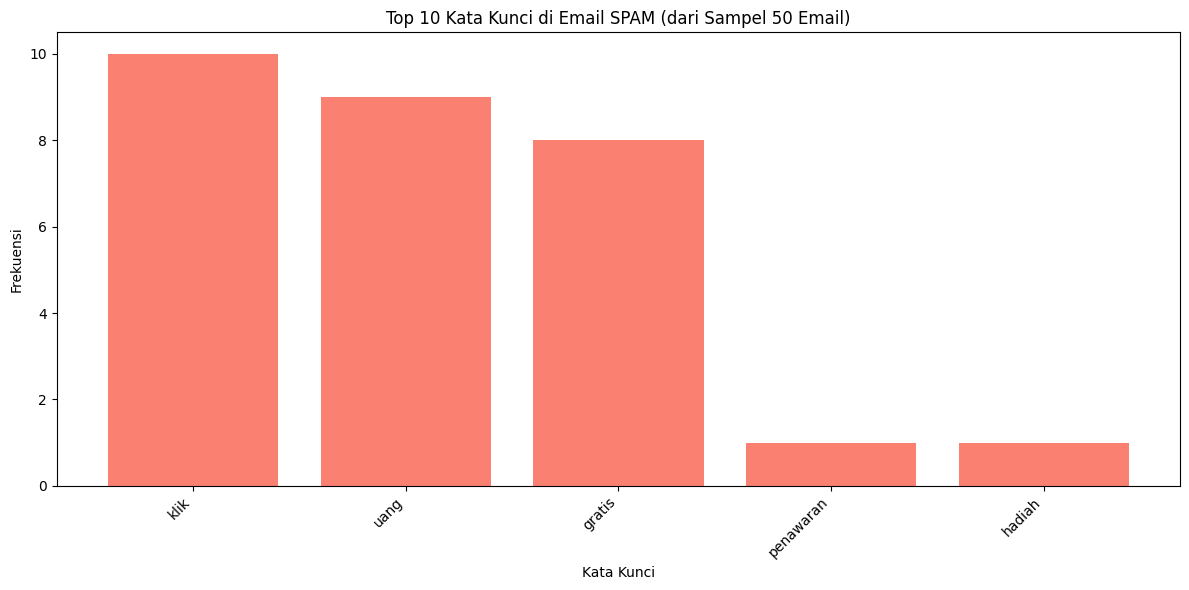


5 Kata Kunci Teratas di Email HAM (dari sampel):
- selamat: 4
- klik: 3


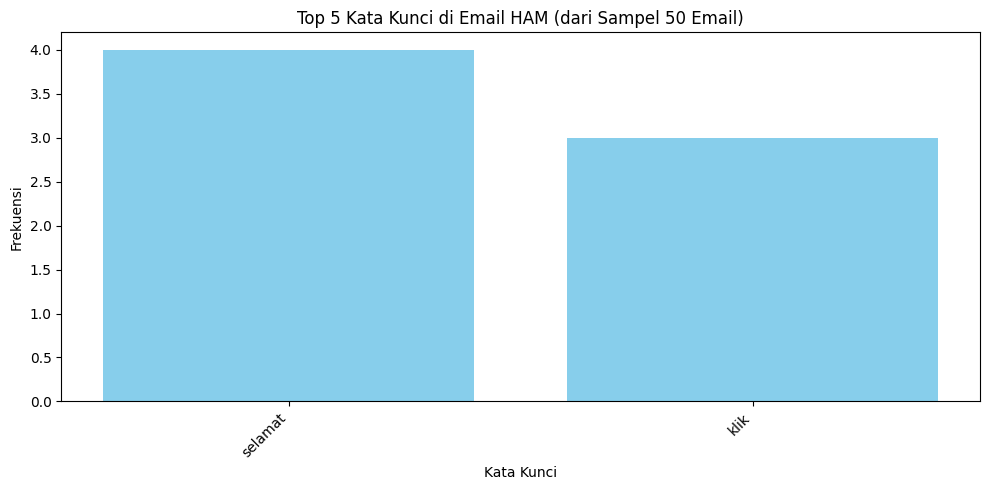


Visualisasi untuk Goal 4 (Kata Kunci Spam) selesai.


In [ ]:
# Sel 17: Visualisasi Frekuensi Kata Kunci Spam

import matplotlib.pyplot as plt
from collections import Counter

print("--- Visualisasi Frekuensi Kata Kunci Spam ---")

# Pastikan keywords_in_spam dan keywords_in_ham sudah terdefinisi dari Sel 16
if ('keywords_in_spam' in globals() and 'keywords_in_ham' in globals() and
    (keywords_in_spam or keywords_in_ham)): # Lanjutkan hanya jika ada data

    # --- Analisis Frekuensi untuk Email SPAM ---
    if keywords_in_spam:
        spam_keyword_counts = Counter(keywords_in_spam)
        # Ambil N kata kunci teratas (misalnya, 10 teratas)
        top_n_spam = 10
        most_common_spam_keywords = spam_keyword_counts.most_common(top_n_spam)

        print(f"\n{top_n_spam} Kata Kunci Teratas di Email SPAM (dari sampel):")
        for keyword, count in most_common_spam_keywords:
            print(f"- {keyword}: {count}")

        # Persiapan data untuk plot spam
        spam_words, spam_counts = zip(*most_common_spam_keywords) if most_common_spam_keywords else ([], [])

        # Membuat plot untuk spam
        plt.figure(figsize=(12, 6))
        plt.bar(spam_words, spam_counts, color='salmon')
        plt.xlabel("Kata Kunci")
        plt.ylabel("Frekuensi")
        plt.title(f"Top {top_n_spam} Kata Kunci di Email SPAM (dari Sampel {num_samples} Email)")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout() # Menyesuaikan layout agar label tidak terpotong
        plt.show()
    else:
        print("\nTidak ada kata kunci ditemukan di email SPAM (dari sampel) untuk divisualisasikan.")

    # --- Analisis Frekuensi untuk Email HAM ---
    if keywords_in_ham:
        ham_keyword_counts = Counter(keywords_in_ham)
        # Ambil N kata kunci teratas (misalnya, 5 teratas karena mungkin lebih sedikit)
        top_n_ham = 5
        most_common_ham_keywords = ham_keyword_counts.most_common(top_n_ham)

        print(f"\n{top_n_ham} Kata Kunci Teratas di Email HAM (dari sampel):")
        for keyword, count in most_common_ham_keywords:
            print(f"- {keyword}: {count}")

        # Persiapan data untuk plot ham
        ham_words, ham_counts = zip(*most_common_ham_keywords) if most_common_ham_keywords else ([], [])

        # Membuat plot untuk ham (jika ada data)
        if ham_words:
            plt.figure(figsize=(10, 5))
            plt.bar(ham_words, ham_counts, color='skyblue')
            plt.xlabel("Kata Kunci")
            plt.ylabel("Frekuensi")
            plt.title(f"Top {top_n_ham} Kata Kunci di Email HAM (dari Sampel {num_samples} Email)")
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            plt.show()
        else:
            print("\nTidak ada kata kunci yang cukup signifikan di email HAM (dari sampel) untuk ditampilkan dalam plot terpisah.")

    # --- Perbandingan Kata Kunci Umum (Opsional, jika ingin membandingkan kata yang sama) ---
    # Anda bisa membuat plot perbandingan jika ada kata kunci yang muncul di kedua kategori
    # atau membandingkan total kemunculan semua kata kunci.
    # Untuk saat ini, kita fokus pada plot terpisah.

else:
    print("\nTidak ada data kata kunci yang dikumpulkan dari Sel 16 untuk divisualisasikan.")
    if 'keywords_in_spam' not in globals() or 'keywords_in_ham' not in globals():
        print("- Variabel 'keywords_in_spam' atau 'keywords_in_ham' tidak terdefinisi.")
    elif not keywords_in_spam and not keywords_in_ham:
        print("- List 'keywords_in_spam' dan 'keywords_in_ham' keduanya kosong.")

print("\nVisualisasi untuk Goal 4 (Kata Kunci Spam) selesai.")

## 7. Goal 5: Mengidentifikasi Penggunaan Tanda Baca Berlebihan

**Tujuan:** Mendeteksi pola penggunaan tanda baca yang berlebihan, seperti beberapa tanda seru (`!!!`), beberapa tanda tanya (`???`), atau kombinasi keduanya (`?!?!`) secara berturut-turut. Pola ini sering digunakan dalam email spam untuk menciptakan urgensi atau menarik perhatian.

### 7.1 Persiapan Contoh Teks Statis untuk Goal 5

In [ ]:
# Sel 18: Persiapan Contoh Teks Statis untuk Goal 5

static_text_excess_punct_1 = "Penawaran terbatas!!! Jangan sampai ketinggalan! Apa Anda yakin?!?"
static_text_excess_punct_2 = "GRATIS!!! Hanya untuk hari ini???"
static_text_excess_punct_3 = "Ini penting! Tapi ini normal? Satu tanda saja."
static_text_no_excess_punct = "Ini adalah email biasa dengan tanda baca standar. Tidak ada yang berlebihan."
static_text_mixed_punct = "Apakah ini benar?!?!?! Saya tidak percaya!!! Hubungi kami sekarang."

texts_to_test_excess_punct = {
    "Excess Punct 1": static_text_excess_punct_1,
    "Excess Punct 2": static_text_excess_punct_2,
    "Excess Punct 3 (Normal)": static_text_excess_punct_3,
    "No Excess Punct": static_text_no_excess_punct,
    "Mixed Excess Punct": static_text_mixed_punct
}

print("--- Contoh Teks untuk Goal 5 (Tanda Baca Berlebihan) ---")
for name, text in texts_to_test_excess_punct.items():
    print(f"'{name}': {text}")

print("\nPersiapan untuk Goal 5 (Tanda Baca Berlebihan) selesai.")

--- Contoh Teks untuk Goal 5 (Tanda Baca Berlebihan) ---
'Excess Punct 1': Penawaran terbatas!!! Jangan sampai ketinggalan! Apa Anda yakin?!?
'Excess Punct 2': GRATIS!!! Hanya untuk hari ini???
'Excess Punct 3 (Normal)': Ini penting! Tapi ini normal? Satu tanda saja.
'No Excess Punct': Ini adalah email biasa dengan tanda baca standar. Tidak ada yang berlebihan.
'Mixed Excess Punct': Apakah ini benar?!?!?! Saya tidak percaya!!! Hubungi kami sekarang.

Persiapan untuk Goal 5 (Tanda Baca Berlebihan) selesai.


### 7.2 Menerapkan Regex untuk Tanda Baca Berlebihan pada Contoh Teks Statis

Kita akan mencoba beberapa variasi regex untuk menangkap pola tanda baca berlebihan.

In [ ]:
# Sel 19: Menerapkan Regex Tanda Baca Berlebihan pada Contoh Teks Statis

print("--- Menerapkan Regex Tanda Baca Berlebihan pada Contoh Teks Statis ---")

# texts_to_test_excess_punct sudah terdefinisi di Sel 18

# Variasi 1: Mencari minimal dua tanda seru berturut-turut ATAU minimal dua tanda tanya berturut-turut
print("\n--- Variasi 1: Minimal 2 tanda seru ATAU minimal 2 tanda tanya ---")
regex_punct_v1 = r"!{2,}|\?{2,}"
# Penjelasan:
# !{2,} : Mencocokkan karakter '!' dua kali atau lebih secara berturut-turut.
# |      : Operator OR.
# \?{2,} : Mencocokkan karakter '?' dua kali atau lebih secara berturut-turut.
#          Tanda tanya perlu di-escape (\?) karena '?' adalah meta-karakter regex (0 atau 1 kali).
for name, text in texts_to_test_excess_punct.items():
    matches = re.findall(regex_punct_v1, text)
    print(f"Di '{name}': {matches}")

# Variasi 2: Mencari minimal dua karakter dari set [!?] secara berturut-turut
print("\n--- Variasi 2: Minimal 2 karakter dari set [!?] berturut-turut ---")
regex_punct_v2 = r"[!?]{2,}"
# Penjelasan:
# [!?]  : Kelas karakter, cocok dengan '!' ATAU '?'.
# {2,}  : Kuantifier, mencocokkan kelas karakter sebelumnya dua kali atau lebih secara berturut-turut.
# Pola ini lebih ringkas dan bisa menangkap kombinasi seperti "!?" atau "?!" jika muncul minimal 2 kali (misal, "!?!!").
# Namun, jika kita ingin menangkap "!??" sebagai satu kesatuan, ini sudah benar.
for name, text in texts_to_test_excess_punct.items():
    matches = re.findall(regex_punct_v2, text)
    print(f"Di '{name}': {matches}")

# Variasi 3: Lebih spesifik, mencari urutan yang hanya terdiri dari ! dan ?, minimal panjang 2,
#            dan memastikan tidak ada karakter lain di antaranya.
#            Ini mirip dengan V2, tetapi kita bisa lebih eksplisit tentang apa yang kita anggap "berlebihan".
#            Misalnya, kita bisa mencari urutan yang terdiri dari minimal X tanda seru/tanya,
#            atau urutan yang memiliki proporsi tanda seru/tanya yang tinggi.
#            Untuk tugas ini, V2 sudah cukup baik untuk menangkap "urutan tanda seru/tanya".
#            Mari kita coba variasi yang memastikan ada setidaknya satu tanda seru DAN satu tanda tanya
#            dalam urutan berlebihan tersebut, atau banyak tanda seru/tanya.

print("\n--- Variasi 3: Urutan campuran [!?] minimal 3, ATAU hanya !!!+, ATAU hanya ???+ ---")
# Ini lebih untuk eksplorasi, V2 mungkin lebih praktis.
# Regex ini mencari:
# 1. Urutan campuran ! dan ? yang panjangnya minimal 3 (e.g., !?!, !!?, ???!)
# 2. Atau, tiga atau lebih tanda seru (!!!+)
# 3. Atau, tiga atau lebih tanda tanya (???+)
regex_punct_v3 = r"(?:[!?]{3,})|(?:!{3,})|(?:\?{3,})"
# Penjelasan:
# (?:[!?]{3,}) : Grup non-penangkap, cocok dengan 3 atau lebih karakter dari set [!?]. Ini akan menangkap "!!!", "???", "!?!", "??!", dll.
# |(?:!{3,})   : ATAU 3 atau lebih tanda seru.
# |(?:\?{3,})  : ATAU 3 atau lebih tanda tanya.
# Sebenarnya, (?:[!?]{3,}) sudah mencakup (?:!{3,}) dan (?:\?{3,}). Jadi, kita bisa sederhanakan.
# Mari kita buat V3 lebih fokus pada "minimal 3 tanda baca jenis ! atau ? secara berurutan".
regex_punct_v3_simplified = r"[!?]{3,}" # Minimal 3 tanda seru/tanya/kombinasi berturut-turut

print("Menggunakan V3 Simplified: [!?]{3,} (Minimal 3 tanda ! atau ? atau kombinasi)")
for name, text in texts_to_test_excess_punct.items():
    matches = re.findall(regex_punct_v3_simplified, text)
    print(f"Di '{name}': {matches}")


# Variasi 4: Menggunakan lookarounds untuk menemukan tanda baca yang "berlebihan"
#            tanpa harus menangkap seluruh urutannya, atau untuk mengidentifikasi
#            konteks di sekitarnya. Ini bisa jadi terlalu kompleks untuk kebutuhan saat ini.
#            Untuk tugas ini, menangkap urutan berlebihannya (seperti di V2 atau V3 simplified) sudah cukup.

# Kita akan anggap regex_punct_v2 ([!?]{2,}) sebagai regex yang cukup baik dan umum.
# Atau regex_punct_v3_simplified ([!?]{3,}) jika kita ingin lebih ketat (minimal 3).
# Mari kita gunakan [!?]{2,} untuk penerapan ke dataset karena lebih sensitif.

print("\nPenerapan regex tanda baca berlebihan pada contoh teks statis selesai.")

--- Menerapkan Regex Tanda Baca Berlebihan pada Contoh Teks Statis ---

--- Variasi 1: Minimal 2 tanda seru ATAU minimal 2 tanda tanya ---
Di 'Excess Punct 1': ['!!!']
Di 'Excess Punct 2': ['!!!', '???']
Di 'Excess Punct 3 (Normal)': []
Di 'No Excess Punct': []
Di 'Mixed Excess Punct': ['!!!']

--- Variasi 2: Minimal 2 karakter dari set [!?] berturut-turut ---
Di 'Excess Punct 1': ['!!!', '?!?']
Di 'Excess Punct 2': ['!!!', '???']
Di 'Excess Punct 3 (Normal)': []
Di 'No Excess Punct': []
Di 'Mixed Excess Punct': ['?!?!?!', '!!!']

--- Variasi 3: Urutan campuran [!?] minimal 3, ATAU hanya !!!+, ATAU hanya ???+ ---
Menggunakan V3 Simplified: [!?]{3,} (Minimal 3 tanda ! atau ? atau kombinasi)
Di 'Excess Punct 1': ['!!!', '?!?']
Di 'Excess Punct 2': ['!!!', '???']
Di 'Excess Punct 3 (Normal)': []
Di 'No Excess Punct': []
Di 'Mixed Excess Punct': ['?!?!?!', '!!!']

Penerapan regex tanda baca berlebihan pada contoh teks statis selesai.


### 7.3 Menerapkan Regex Tanda Baca Berlebihan pada Sampel dari Dataset dan Mengumpulkan Data untuk Visualisasi

Kita akan menerapkan regex `[!?]{2,}` pada sampel email dari `df_email` untuk menemukan pola tanda baca berlebihan. Kita juga akan mengumpulkan data ini untuk persiapan visualisasi.

In [ ]:
# Sel 20: Menerapkan Regex Tanda Baca Berlebihan pada Sampel DataFrame dan Mengumpulkan Data

print("\n--- Menerapkan Regex Tanda Baca Berlebihan pada Sampel Dataset ---")

# Definisikan regex yang akan kita gunakan (berdasarkan Sel 19, V2 adalah pilihan yang baik)
regex_excess_punctuation = r"[!?]{2,}"

# Pastikan df_email, kolom_teks, dan kolom_label sudah terdefinisi
if ('df_email' in globals() and df_email is not None and not df_email.empty and
    'kolom_teks' in globals() and kolom_teks in df_email.columns and
    'kolom_label' in globals() and kolom_label in df_email.columns):

    # Data untuk menyimpan semua pola tanda baca berlebihan yang ditemukan
    all_found_excess_punctuation = []

    # Untuk melihat beberapa contoh email dengan pola yang ditemukan
    found_punct_examples = {}

    # Hitung berapa banyak email spam dan ham yang mengandung pola ini
    spam_with_excess_punct_count = 0
    ham_with_excess_punct_count = 0

    # Total email spam dan ham dalam sampel (untuk persentase nanti)
    total_spam_in_sample = 0
    total_ham_in_sample = 0

    num_samples = min(50, len(df_email)) # Ambil hingga 50 sampel
    sample_df_punct = df_email.sample(n=num_samples, random_state=567) if len(df_email) > num_samples else df_email

    print(f"Menganalisis {len(sample_df_punct)} sampel email dari DataFrame untuk tanda baca berlebihan...")

    for index, row in sample_df_punct.iterrows():
        email_text_content = str(row[kolom_teks])
        label_val = row[kolom_label] # Asumsi label 1 untuk spam, 0 untuk ham

        # Update total spam/ham dalam sampel
        if label_val == 1:
            total_spam_in_sample += 1
        elif label_val == 0:
            total_ham_in_sample += 1

        matches = re.findall(regex_excess_punctuation, email_text_content)

        if matches:
            all_found_excess_punctuation.extend(matches) # Kumpulkan semua match

            # Simpan contoh untuk ditampilkan (misalnya, 5 contoh pertama)
            if len(found_punct_examples) < 5:
                found_punct_examples[f"Email Index {index} (Label: {label_val})"] = {
                    "text_snippet": email_text_content[:200] + "...", # Cuplikan teks
                    "patterns_found": list(set(matches)) # Pola unik yang ditemukan di email ini
                }

            # Hitung email yang mengandung pola ini per kategori
            if label_val == 1: # Spam
                spam_with_excess_punct_count += 1
            elif label_val == 0: # Ham
                ham_with_excess_punct_count += 1

    # Cetak beberapa contoh email dengan pola yang ditemukan
    if found_punct_examples:
        print("\n--- Contoh Email dengan Tanda Baca Berlebihan Ditemukan ---")
        for source, data in found_punct_examples.items():
            print(f"\n{source}:")
            print(f"  Cuplikan: {data['text_snippet']}")
            print(f"  Pola Ditemukan: {data['patterns_found']}")
    else:
        print("\nTidak ada tanda baca berlebihan ditemukan dalam sampel yang diproses untuk ditampilkan sebagai contoh.")

    # Informasi ringkasan
    print(f"\nTotal pola tanda baca berlebihan ditemukan (semua kemunculan): {len(all_found_excess_punctuation)}")
    if total_spam_in_sample > 0:
        percentage_spam_with_punct = (spam_with_excess_punct_count / total_spam_in_sample) * 100 if total_spam_in_sample > 0 else 0
        print(f"Jumlah email SPAM (dari sampel) yang mengandung tanda baca berlebihan: {spam_with_excess_punct_count} dari {total_spam_in_sample} ({percentage_spam_with_punct:.2f}%)")
    else:
        print("Tidak ada email SPAM dalam sampel untuk dianalisis.")

    if total_ham_in_sample > 0:
        percentage_ham_with_punct = (ham_with_excess_punct_count / total_ham_in_sample) * 100 if total_ham_in_sample > 0 else 0
        print(f"Jumlah email HAM (dari sampel) yang mengandung tanda baca berlebihan: {ham_with_excess_punct_count} dari {total_ham_in_sample} ({percentage_ham_with_punct:.2f}%)")
    else:
        print("Tidak ada email HAM dalam sampel untuk dianalisis.")

    if not all_found_excess_punctuation:
        print("\nTidak ada pola tanda baca berlebihan yang ditemukan dalam sampel email yang dianalisis.")

else:
    print("\nGAGAL menjalankan analisis tanda baca berlebihan pada DataFrame.")
    # ... (tambahkan pengecekan variabel lain jika perlu) ...

print("\nPengumpulan data tanda baca berlebihan dari sampel DataFrame selesai.")


--- Menerapkan Regex Tanda Baca Berlebihan pada Sampel Dataset ---
Menganalisis 50 sampel email dari DataFrame untuk tanda baca berlebihan...

Tidak ada tanda baca berlebihan ditemukan dalam sampel yang diproses untuk ditampilkan sebagai contoh.

Total pola tanda baca berlebihan ditemukan (semua kemunculan): 0
Jumlah email SPAM (dari sampel) yang mengandung tanda baca berlebihan: 0 dari 33 (0.00%)
Jumlah email HAM (dari sampel) yang mengandung tanda baca berlebihan: 0 dari 17 (0.00%)

Tidak ada pola tanda baca berlebihan yang ditemukan dalam sampel email yang dianalisis.

Pengumpulan data tanda baca berlebihan dari sampel DataFrame selesai.


### 7.4 Visualisasi untuk Tanda Baca Berlebihan

Berdasarkan data yang dikumpulkan, kita akan mencoba memvisualisasikan temuan terkait tanda baca berlebihan.

In [ ]:
# Sel 21: Visualisasi untuk Tanda Baca Berlebihan

import matplotlib.pyplot as plt
from collections import Counter # Meskipun mungkin tidak terpakai jika tidak ada data

print("--- Visualisasi untuk Tanda Baca Berlebihan ---")

# Pastikan variabel yang relevan dari Sel 20 sudah terdefinisi
# Variabel utama yang kita perlukan adalah:
# all_found_excess_punctuation, spam_with_excess_punct_count, ham_with_excess_punct_count,
# total_spam_in_sample, total_ham_in_sample

if ('all_found_excess_punctuation' in globals() and
    'spam_with_excess_punct_count' in globals() and
    'ham_with_excess_punct_count' in globals() and
    'total_spam_in_sample' in globals() and
    'total_ham_in_sample' in globals()):

    if all_found_excess_punctuation:
        # Jika ada data, kita bisa membuat visualisasi frekuensi pola yang ditemukan
        # atau perbandingan persentase email spam/ham yang mengandung pola tersebut.

        # 1. Frekuensi Pola Tanda Baca Berlebihan yang Ditemukan
        punct_pattern_counts = Counter(all_found_excess_punctuation)
        top_n_punct = 10 # Ambil N pola teratas
        most_common_punct_patterns = punct_pattern_counts.most_common(top_n_punct)

        if most_common_punct_patterns:
            patterns, counts = zip(*most_common_punct_patterns)

            plt.figure(figsize=(10, 5))
            plt.bar(patterns, counts, color='lightcoral')
            plt.xlabel("Pola Tanda Baca Berlebihan")
            plt.ylabel("Frekuensi Kemunculan")
            plt.title(f"Top {top_n_punct} Pola Tanda Baca Berlebihan Ditemukan (dari Sampel {num_samples} Email)")
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            plt.show()
        else:
            print("Meskipun list 'all_found_excess_punctuation' ada, tidak ada pola yang cukup signifikan untuk divisualisasikan frekuensinya.")

        # 2. Perbandingan Persentase Email Spam vs Ham yang Mengandung Pola
        labels = ['SPAM', 'HAM']
        counts_with_pattern = [spam_with_excess_punct_count, ham_with_excess_punct_count]
        totals_in_sample = [total_spam_in_sample, total_ham_in_sample]

        # Hanya buat plot jika ada email di sampel untuk setidaknya satu kategori
        if total_spam_in_sample > 0 or total_ham_in_sample > 0:
            percentages = []
            actual_counts_for_plot = []
            actual_labels_for_plot = []

            if total_spam_in_sample > 0:
                percentages.append((spam_with_excess_punct_count / total_spam_in_sample) * 100)
                actual_counts_for_plot.append(spam_with_excess_punct_count)
                actual_labels_for_plot.append(f"SPAM\n({spam_with_excess_punct_count}/{total_spam_in_sample})")
            else: # Jika tidak ada spam di sampel, kita bisa skip atau beri nilai 0
                percentages.append(0)
                actual_counts_for_plot.append(0)
                actual_labels_for_plot.append(f"SPAM\n(0/0)")


            if total_ham_in_sample > 0:
                percentages.append((ham_with_excess_punct_count / total_ham_in_sample) * 100)
                actual_counts_for_plot.append(ham_with_excess_punct_count)
                actual_labels_for_plot.append(f"HAM\n({ham_with_excess_punct_count}/{total_ham_in_sample})")
            else: # Jika tidak ada ham di sampel
                percentages.append(0)
                actual_counts_for_plot.append(0)
                actual_labels_for_plot.append(f"HAM\n(0/0)")

            plt.figure(figsize=(8, 6))
            bars = plt.bar(actual_labels_for_plot, percentages, color=['lightcoral', 'lightskyblue'])
            plt.ylabel("Persentase Email (%)")
            plt.title(f"Persentase Email Mengandung Tanda Baca Berlebihan (dari Sampel {num_samples} Email)")
            plt.ylim(0, 100) # Persentase dari 0 hingga 100

            # Tambahkan teks persentase di atas bar
            for i, bar in enumerate(bars):
                yval = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2.0, yval + 2, f'{percentages[i]:.2f}%', ha='center', va='bottom')

            plt.tight_layout()
            plt.show()
        else:
            print("Tidak ada email spam atau ham dalam sampel untuk membuat plot perbandingan.")

    else:
        print("Tidak ada data tanda baca berlebihan yang ditemukan di Sel 20 untuk divisualisasikan.")
        print(f"(Jumlah email SPAM dengan pola: {spam_with_excess_punct_count} dari {total_spam_in_sample})")
        print(f"(Jumlah email HAM dengan pola: {ham_with_excess_punct_count} dari {total_ham_in_sample})")

else:
    print("\nVariabel yang diperlukan untuk visualisasi tidak terdefinisi. Pastikan Sel 20 sudah dijalankan.")

print("\nProses untuk Goal 5 (Tanda Baca Berlebihan) selesai.")

--- Visualisasi untuk Tanda Baca Berlebihan ---
Tidak ada data tanda baca berlebihan yang ditemukan di Sel 20 untuk divisualisasikan.
(Jumlah email SPAM dengan pola: 0 dari 33)
(Jumlah email HAM dengan pola: 0 dari 17)

Proses untuk Goal 5 (Tanda Baca Berlebihan) selesai.


## 8. **Downstream Analysis**: Analisis Frekuensi Kata Kunci Spam pada Seluruh Dataset

Setelah melakukan eksplorasi dengan regex, kita akan melakukan analisis lebih lanjut pada temuan dari Goal 4 (Kata Kunci Spam). Kita akan menerapkan pencarian kata kunci pada seluruh dataset `df_email` untuk mendapatkan gambaran yang lebih komprehensif dan memvisualisasikan perbandingan frekuensi kata kunci antara email spam dan ham.

### 8.1 Ekstraksi Kata Kunci dari Seluruh Dataset

In [ ]:
# Sel 22: Ekstraksi Kata Kunci dari Seluruh Dataset

print("\n--- Downstream Analysis: Ekstraksi Kata Kunci dari Seluruh Dataset ---")

# Pastikan df_email, kolom_teks, kolom_label, dan regex_spam_keywords_pattern_string sudah terdefinisi
if ('df_email' in globals() and df_email is not None and not df_email.empty and
    'kolom_teks' in globals() and kolom_teks in df_email.columns and
    'kolom_label' in globals() and kolom_label in df_email.columns and
    'regex_spam_keywords_pattern_string' in globals()):

    # Data untuk menyimpan semua kata kunci yang ditemukan per kategori (spam/ham) dari seluruh dataset
    all_keywords_in_spam_full = []
    all_keywords_in_ham_full = []

    # Hitung total email spam dan ham di seluruh dataset
    total_spam_full_dataset = df_email[df_email[kolom_label] == 1].shape[0]
    total_ham_full_dataset = df_email[df_email[kolom_label] == 0].shape[0]

    print(f"Menganalisis {len(df_email)} email dari seluruh DataFrame untuk kata kunci spam...")

    for index, row in df_email.iterrows(): # Iterasi melalui seluruh DataFrame
        email_text_content = str(row[kolom_teks])
        label_val = row[kolom_label]

        matches = re.findall(regex_spam_keywords_pattern_string, email_text_content, re.IGNORECASE)

        if matches:
            normalized_matches = [match.lower() for match in matches]

            if label_val == 1: # Spam
                all_keywords_in_spam_full.extend(normalized_matches)
            elif label_val == 0: # Ham
                all_keywords_in_ham_full.extend(normalized_matches)

    print(f"\nEkstraksi dari seluruh dataset selesai.")
    print(f"Total kata kunci ditemukan di {total_spam_full_dataset} email SPAM (seluruh dataset): {len(all_keywords_in_spam_full)}")
    print(f"Total kata kunci ditemukan di {total_ham_full_dataset} email HAM (seluruh dataset): {len(all_keywords_in_ham_full)}")

    if not all_keywords_in_spam_full and not all_keywords_in_ham_full:
        print("\nTidak ada kata kunci spam dari daftar yang ditemukan dalam seluruh dataset.")

else:
    print("\nGAGAL menjalankan ekstraksi kata kunci dari seluruh dataset.")
    # ... (tambahkan pengecekan variabel lain jika perlu) ...

print("\nProses ekstraksi kata kunci untuk downstream analysis selesai.")


--- Downstream Analysis: Ekstraksi Kata Kunci dari Seluruh Dataset ---
Menganalisis 254 email dari seluruh DataFrame untuk kata kunci spam...

Ekstraksi dari seluruh dataset selesai.
Total kata kunci ditemukan di 181 email SPAM (seluruh dataset): 135
Total kata kunci ditemukan di 73 email HAM (seluruh dataset): 20

Proses ekstraksi kata kunci untuk downstream analysis selesai.


### 8.2 Analisis Frekuensi dan Visualisasi Perbandingan Kata Kunci (Seluruh Dataset)

--- Downstream Analysis: Analisis Frekuensi & Visualisasi Kata Kunci (Seluruh Dataset) ---

15 Kata Kunci Teratas di Email SPAM (Seluruh Dataset):
- uang: 42
- gratis: 30
- klik: 20
- hadiah: 18
- penawaran: 8
- investasi: 4
- selamat: 3
- segera: 3
- bonus: 2
- penting: 2
- termurah: 1
- promo: 1
- keuntungan: 1

15 Kata Kunci Teratas di Email HAM (Seluruh Dataset):
- klik: 10
- selamat: 9
- uang: 1

--- Data Perbandingan Frekuensi Kata Kunci (Teratas Gabungan) ---
   KataKunci  Frekuensi Spam  Frekuensi Ham
0      bonus               2              0
1     gratis              30              0
2     hadiah              18              0
3  investasi               4              0
4       klik              20             10
5  penawaran               8              0
6    penting               2              0
7     segera               3              0
8    selamat               3              9
9       uang              42              1


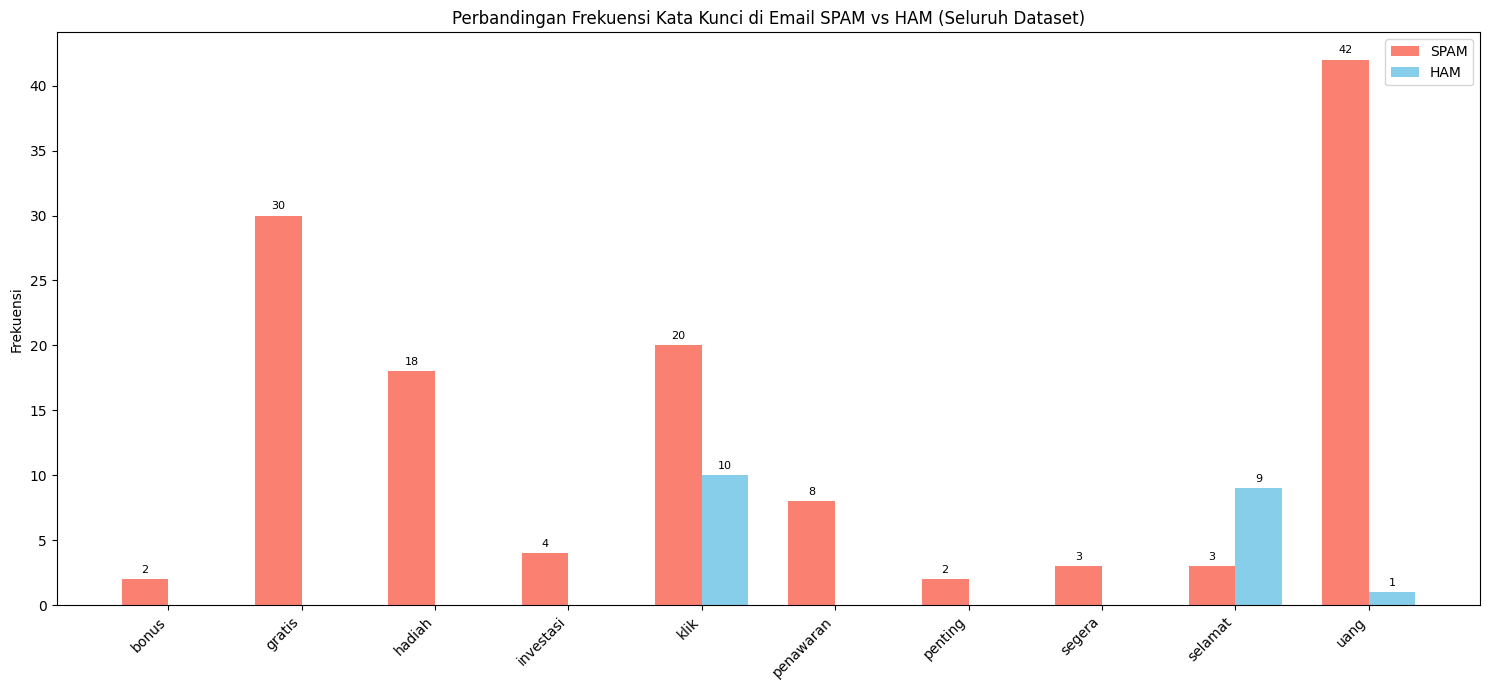


Downstream analysis dan visualisasi selesai.


In [ ]:
# Sel 23: Analisis Frekuensi dan Visualisasi Perbandingan Kata Kunci (Seluruh Dataset)

import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd # Untuk membuat DataFrame yang memudahkan plotting perbandingan
import numpy as np # Untuk pengaturan posisi bar di plot

print("--- Downstream Analysis: Analisis Frekuensi & Visualisasi Kata Kunci (Seluruh Dataset) ---")

# Pastikan all_keywords_in_spam_full dan all_keywords_in_ham_full sudah terdefinisi dari Sel 22
if ('all_keywords_in_spam_full' in globals() and 'all_keywords_in_ham_full' in globals() and
    (all_keywords_in_spam_full or all_keywords_in_ham_full)):

    # --- Frekuensi Kata Kunci di Email SPAM (Seluruh Dataset) ---
    if all_keywords_in_spam_full:
        spam_keyword_counts_full = Counter(all_keywords_in_spam_full)
        top_n_spam_full = 15 # Ambil lebih banyak kata kunci
        most_common_spam_full = spam_keyword_counts_full.most_common(top_n_spam_full)
        print(f"\n{top_n_spam_full} Kata Kunci Teratas di Email SPAM (Seluruh Dataset):")
        for keyword, count in most_common_spam_full:
            print(f"- {keyword}: {count}")
    else:
        spam_keyword_counts_full = Counter() # Counter kosong jika tidak ada data
        print("\nTidak ada kata kunci ditemukan di email SPAM (seluruh dataset).")

    # --- Frekuensi Kata Kunci di Email HAM (Seluruh Dataset) ---
    if all_keywords_in_ham_full:
        ham_keyword_counts_full = Counter(all_keywords_in_ham_full)
        top_n_ham_full = 15
        most_common_ham_full = ham_keyword_counts_full.most_common(top_n_ham_full)
        print(f"\n{top_n_ham_full} Kata Kunci Teratas di Email HAM (Seluruh Dataset):")
        for keyword, count in most_common_ham_full:
            print(f"- {keyword}: {count}")
    else:
        ham_keyword_counts_full = Counter() # Counter kosong jika tidak ada data
        print("\nTidak ada kata kunci ditemukan di email HAM (seluruh dataset).")

    # --- Persiapan Data untuk Plot Perbandingan ---
    # Gabungkan semua kata kunci unik dari spam dan ham untuk sumbu X plot perbandingan
    all_unique_keywords = sorted(list(set(spam_keyword_counts_full.keys()) | set(ham_keyword_counts_full.keys())))

    # Ambil N kata kunci teratas berdasarkan frekuensi total (spam + ham) atau yang paling membedakan
    # Untuk contoh ini, kita ambil N kata kunci teratas dari spam dan N teratas dari ham, lalu gabungkan set uniknya

    # Ambil kata kunci dari spam teratas dan ham teratas
    top_spam_keys = [k[0] for k in most_common_spam_full[:10]] if 'most_common_spam_full' in globals() and most_common_spam_full else []
    top_ham_keys = [k[0] for k in most_common_ham_full[:10]] if 'most_common_ham_full' in globals() and most_common_ham_full else []

    # Gabungkan dan ambil kata kunci unik untuk dibandingkan
    comparison_keywords = sorted(list(set(top_spam_keys + top_ham_keys)))

    if not comparison_keywords and all_unique_keywords: # Fallback jika top_spam/ham kosong tapi ada data
        # Ambil N kata kunci teratas berdasarkan frekuensi gabungan
        combined_counts = spam_keyword_counts_full + ham_keyword_counts_full
        comparison_keywords = [k[0] for k in combined_counts.most_common(10)]


    if comparison_keywords:
        spam_comparison_counts = [spam_keyword_counts_full.get(kw, 0) for kw in comparison_keywords]
        ham_comparison_counts = [ham_keyword_counts_full.get(kw, 0) for kw in comparison_keywords]

        # Membuat DataFrame untuk memudahkan plotting
        df_comparison = pd.DataFrame({
            'KataKunci': comparison_keywords,
            'Frekuensi Spam': spam_comparison_counts,
            'Frekuensi Ham': ham_comparison_counts
        })

        print("\n--- Data Perbandingan Frekuensi Kata Kunci (Teratas Gabungan) ---")
        print(df_comparison)

        # --- Visualisasi Side-by-Side Bar Chart ---
        if not df_comparison.empty:
            x = np.arange(len(df_comparison['KataKunci']))  # Lokasi label
            width = 0.35  # Lebar bar

            fig, ax = plt.subplots(figsize=(15, 7)) # Ukuran plot lebih besar
            rects1 = ax.bar(x - width/2, df_comparison['Frekuensi Spam'], width, label='SPAM', color='salmon')
            rects2 = ax.bar(x + width/2, df_comparison['Frekuensi Ham'], width, label='HAM', color='skyblue')

            # Tambahkan teks, label, judul
            ax.set_ylabel('Frekuensi')
            ax.set_title('Perbandingan Frekuensi Kata Kunci di Email SPAM vs HAM (Seluruh Dataset)')
            ax.set_xticks(x)
            ax.set_xticklabels(df_comparison['KataKunci'], rotation=45, ha="right")
            ax.legend()

            # Fungsi untuk menambahkan label angka di atas bar (opsional, bisa ramai jika banyak bar)
            def autolabel(rects):
                for rect in rects:
                    height = rect.get_height()
                    if height > 0: # Hanya tampilkan label jika frekuensi > 0
                        ax.annotate('{}'.format(height),
                                    xy=(rect.get_x() + rect.get_width() / 2, height),
                                    xytext=(0, 3),  # 3 points vertical offset
                                    textcoords="offset points",
                                    ha='center', va='bottom', fontsize=8)

            autolabel(rects1)
            autolabel(rects2)

            fig.tight_layout()
            plt.show()
        else:
            print("\nTidak ada data yang cukup untuk membuat plot perbandingan kata kunci.")

    else:
        print("\nTidak ada kata kunci yang signifikan untuk dibandingkan frekuensinya.")
else:
    print("\nTidak ada data kata kunci yang dikumpulkan dari Sel 22 untuk dianalisis.")

print("\nDownstream analysis dan visualisasi selesai.")

# **Kesimpulan Akhir**

Analisis Regular Expressions (Regex) pada dataset email spam Indonesia menunjukkan perbedaan karakteristik yang jelas antara email spam dan ham. Ditemukan bahwa email yang teridentifikasi sebagai spam secara signifikan lebih sering mengandung alamat email, nomor telepon, dan URL dibandingkan email ham. Selain itu, kata kunci spesifik yang sering diasosiasikan dengan spam dan fitur stilistik seperti penggunaan huruf kapital berlebih juga menunjukkan frekuensi kemunculan yang jauh lebih tinggi pada kategori spam. Temuan ini mengindikasikan bahwa pola-pola yang diekstraksi menggunakan Regex ini merupakan indikator kuat dan dapat menjadi fitur yang berharga untuk membedakan serta mengklasifikasikan email spam dan ham secara otomatis.